### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [ ]:
# import necessary libraries here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import multiprocessing as mp
from functools import partial
import warnings

# to ignore the warnings for cleaner output
warnings.filterwarnings('ignore')

# for reproducibility
np.random.seed(42)

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

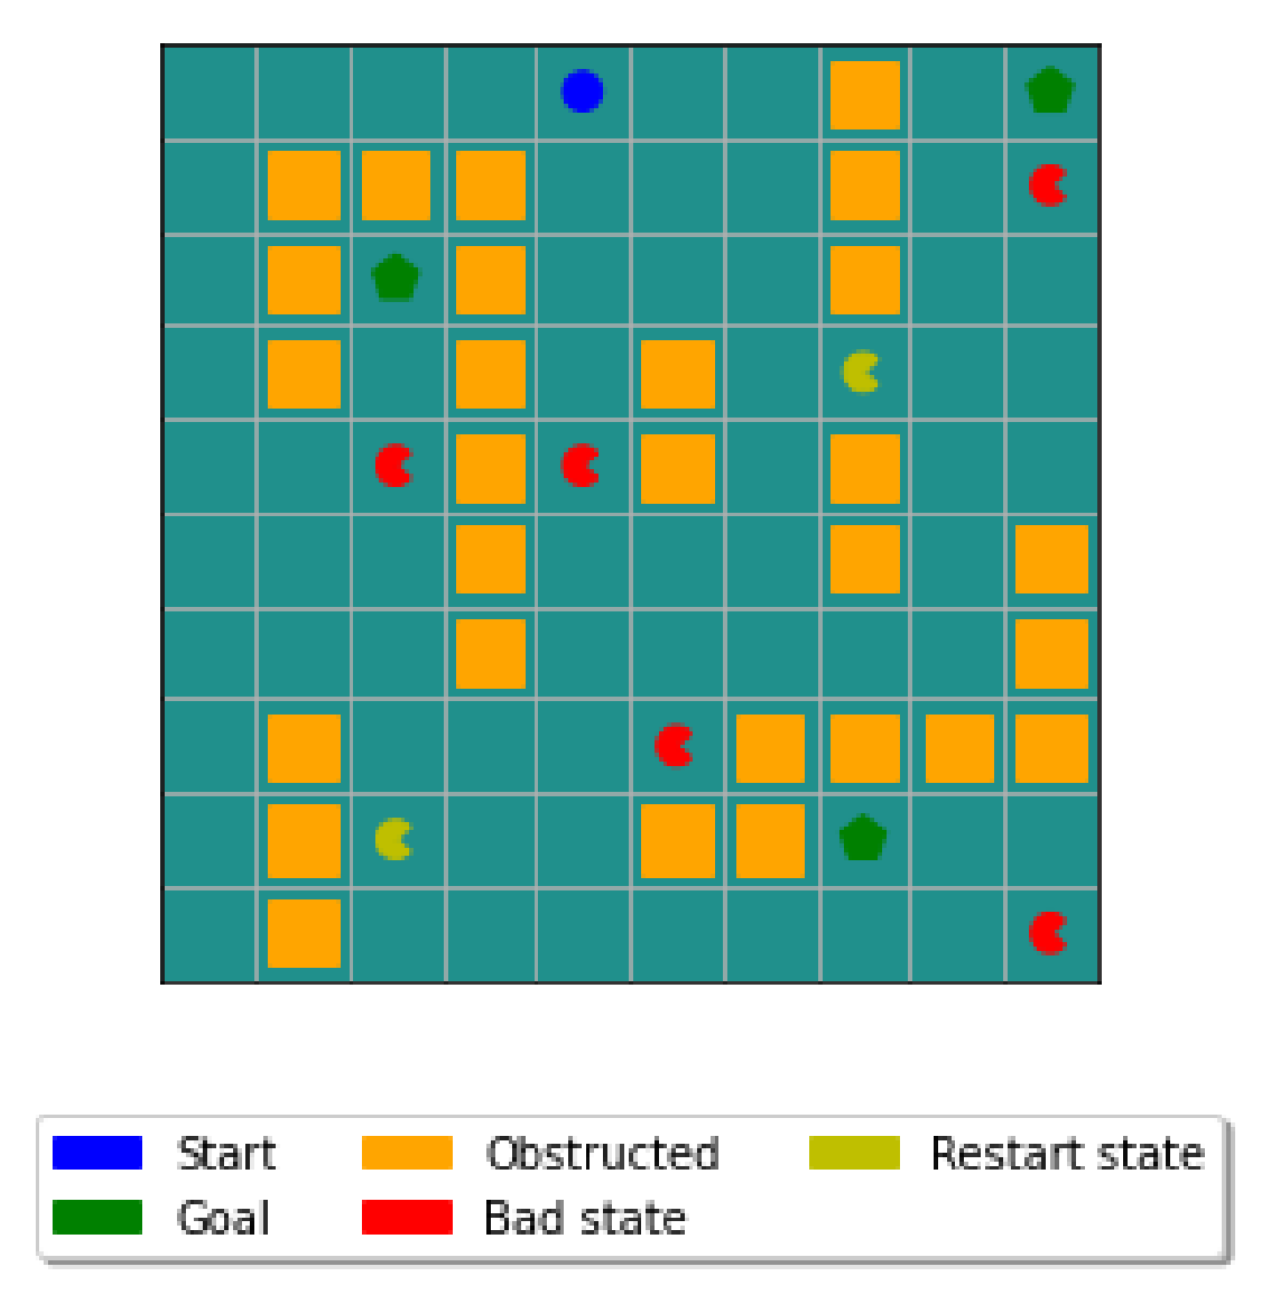

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

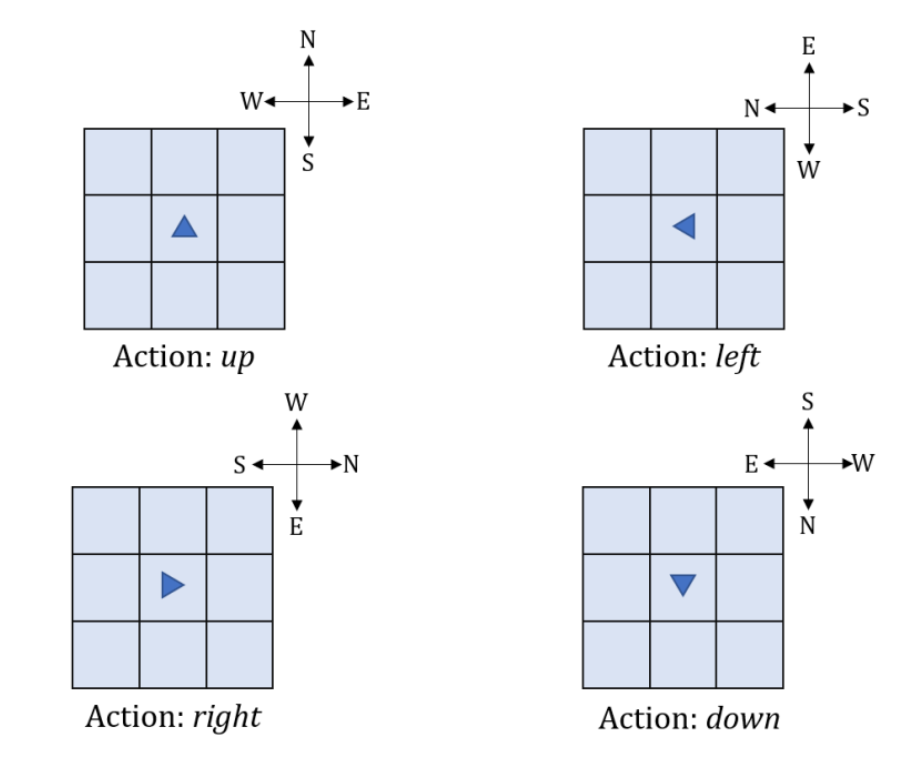

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [ ]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [ ]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

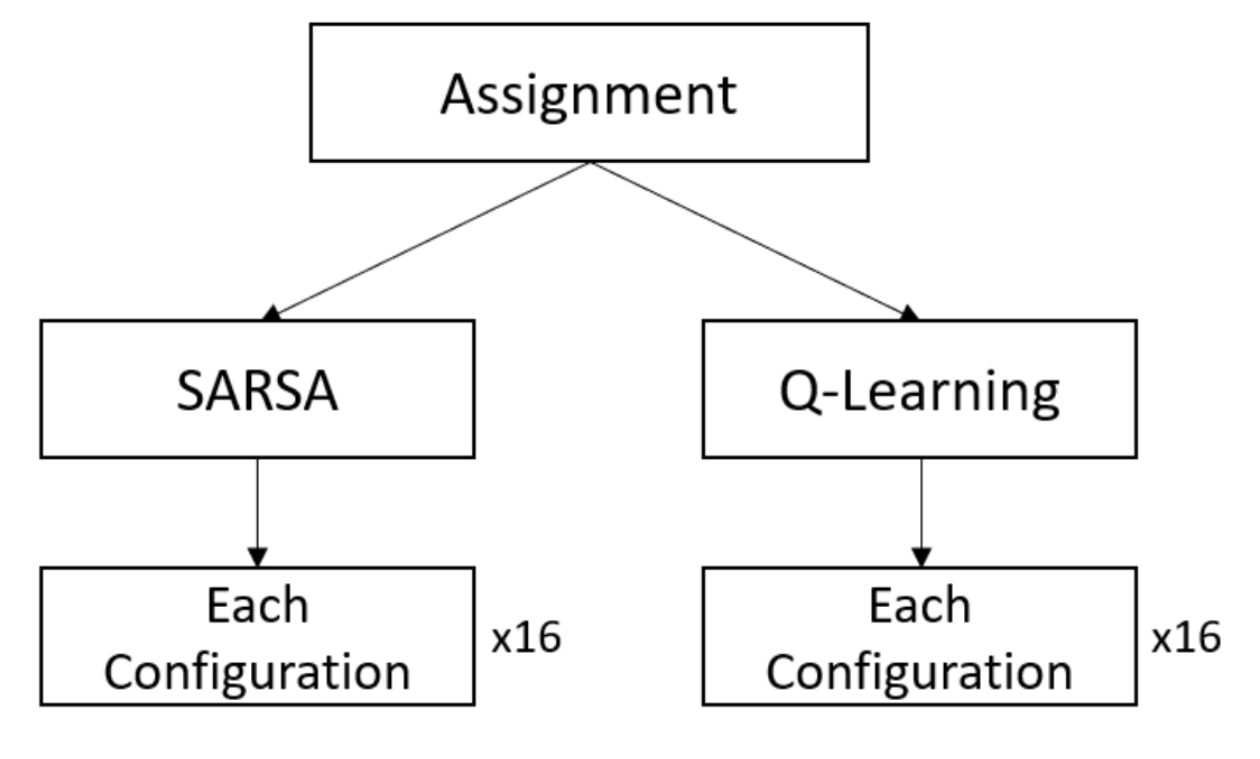

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

### Environment creation

In [ ]:
def environment_creation(start_state, wind, p):

    # specify world parameters

    # size of the grid
    num_cols = 10
    num_rows = 10

    # coordinates of the cells representing obstruction
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                             [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                             [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                             [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

    # list of bad states
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

    # list of restart states
    restart_states = np.array([[3,7],[8,2]])

    # list of goal states i.e. terminal states
    goal_states = np.array([[0,9],[2,2],[8,7]])

    # create the environment's model
    gw = GridWorld(num_rows=num_rows,
                   num_cols=num_cols,
                   start_state=start_state,
                   goal_states=goal_states,
                   wind = wind)

    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)

    gw.add_rewards(step_reward=-1,
                   goal_reward=10,
                   bad_state_reward=-6,
                   restart_state_reward=-100)

    gw.add_transition_probability(p_good_transition=p,
                                  bias=0.5)

    env = gw.create_gridworld()

    return env

### Exploration Strategy

In [ ]:
def epsilon_greedy(epsilon, q_values):

    """Epsilon-greedy exploration strategy."""

    if np.random.random() < epsilon:
        return np.random.choice(len(q_values))
    else:
        return np.argmax(q_values)

def softmax(temperature, q_values):

    """Softmax exploration strategy."""

    # To make sure the exponents do not turn into very large +ve/-ve value,
    # while keeping the probability same, subtract by max
    exp_q = np.exp((q_values-np.max(q_values)) / temperature)
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_values), p=probs)

### Hyperparameter evaluation

In [ ]:
NUM_AGENTS = 30

def train_single_combination(params, env, learning_algorithm, num_agents, strategy):

    """Train agents for a single hyperparameter combination."""

    alpha, gamma, parameter = params

    # Training different agents to deal with the stochasticity
    Q_per_agents = []
    rewards_per_episode_per_agents = []
    steps_per_episode_per_agents = []
    num_visits_per_agents = []

    for _ in range(num_agents):
        Q, rewards_per_episode, steps_per_episode, num_visits = learning_algorithm(
            env=env,
            learning_rate=alpha,
            discount_factor=gamma,
            strategy=strategy,
            parameter=parameter,
        )
        Q_per_agents.append(Q)
        rewards_per_episode_per_agents.append(rewards_per_episode)
        steps_per_episode_per_agents.append(steps_per_episode)
        num_visits_per_agents.append(num_visits)

    # Average across runs
    Q = np.mean(Q_per_agents, axis=0)
    rewards_per_episode = np.mean(rewards_per_episode_per_agents, axis=0)
    steps_per_episode = np.mean(steps_per_episode_per_agents, axis=0)
    num_visits = np.mean(num_visits_per_agents, axis=0)

    # Average for the hyperparameter
    mean_reward = np.mean(rewards_per_episode)
    std_reward = np.std(rewards_per_episode)

    return {
        'learning_rate': alpha,
        'discount_factor': gamma,
        'exploration_parameter': parameter,
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'Q': Q,
        'rewards_per_episode': rewards_per_episode,
        'steps_per_episode': steps_per_episode,
        'num_visits': num_visits
    }

def evaluate_hyperparameters(env, exploration_strategy, learning_algorithm, num_agents=NUM_AGENTS, n_processes=None):

    """Evaluate different hyperparameter combinations in parallel."""

    # Hyperparameter values to test
    learning_rates = [0.001, 0.01, 0.1, 1.0]
    discount_factors = [0.7, 0.8, 0.9, 1.0]
    epsilons = [0.001, 0.01, 0.05, 0.1]
    temperature = [0.01, 0.1, 1, 2]

    if exploration_strategy == "epsilon_greedy":
        parameters = epsilons
        strategy = epsilon_greedy
    elif exploration_strategy == "softmax":
        parameters = temperature
        strategy = softmax
    else:
        raise ValueError("Invalid exploration strategy.")

    # Create all parameter combinations
    param_combinations = list(itertools.product(learning_rates, discount_factors, parameters))
    total_combinations = len(param_combinations)

    # Define the number of processes to use (default to number of CPU cores)
    if n_processes is None:
        n_processes = mp.cpu_count()

    # Create a partial function with fixed arguments
    train_func = partial(
        train_single_combination,
        env=env,
        learning_algorithm=learning_algorithm,
        num_agents=num_agents,
        strategy=strategy
    )

    # Run in parallel
    print(f"Running {total_combinations} hyperparameter combinations on {n_processes} processes...")
    with mp.Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(train_func, param_combinations),
            total=total_combinations,
            desc="Testing hyperparameters"
        ))

    # Sort results by mean reward (descending)
    results.sort(key=lambda x: x['mean_reward'], reverse=True)

    return results

### Reward curve plotting

In [ ]:
def plot_rewards(rewards):

    """Plot reward curve."""

    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.plot(rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.tick_params(axis='y')
    ax1.set_title(f'Rewards per Episode during Training(averaged over {NUM_AGENTS} agents)')

    plt.tight_layout()
    plt.show()

### Steps per episode plotting

In [ ]:
def plot_steps(steps):

    """Plot steps per episode."""

    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.plot(steps)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Steps')
    ax1.tick_params(axis='y')
    ax1.set_title(f'Steps per Episode during Training(averaged over {NUM_AGENTS} agents)')

    plt.tight_layout()
    plt.show()

### State visit heatmap plotting

In [ ]:
def plot_state_visit_heatmap(num_visits,env):

    """Plot heatmap of state visit counts."""

    plt.figure(figsize=(10, 6))
    grid = np.zeros((env.num_rows, env.num_cols))

    for state in range(env.num_states):
        row, col = seq_to_col_row(state, env.num_cols)[0]
        grid[row, col] = num_visits[state]

    # Create heatmap
    sns.heatmap(grid, annot=True, fmt='.0f', cmap="YlGn")
    plt.title(f'State Visit Counts during Training(averaged over {NUM_AGENTS} agents)')
    plt.xlabel('Column')
    plt.ylabel('Row')

    # Mark the goal state
    for goal_state in env.goal_states:
      goal_row, goal_col = goal_state
      plt.gca().add_patch(plt.Rectangle((goal_col, goal_row), 1, 1,
                                        fill=False, edgecolor='green', lw=2))
      plt.text(goal_col, goal_row, 'GOAL',
              color='green', ha='left', va='top')

    # Mark the start state
    for state in env.start_state:
      start_row, start_col = state
      plt.gca().add_patch(plt.Rectangle((start_col, start_row), 1, 1,
                                        fill=False, edgecolor='blue', lw=2))
      plt.text(start_col, start_row, 'START',
              color='blue', ha='left', va='top')

    # Mark the bad state
    for state in env.bad_states:
      row, col = state
      plt.gca().add_patch(plt.Rectangle((col, row), 1, 1,
                                        fill=False, edgecolor='red', lw=2))
      plt.text(col, row, 'BAD',
              color='red', ha='left', va='top')


    # Mark the obstructions
    for state in env.obs_states:
      row, col = state
      plt.gca().add_patch(plt.Rectangle((col, row), 1, 1,
                                        fill=False, edgecolor='orange', lw=2))
      plt.text(col, row, 'OBSTR',
              color='orange', ha='left', va='top')


    # Mark the restart state
    for state in env.restart_states:
      row, col = state
      plt.gca().add_patch(plt.Rectangle((col, row), 1, 1,
                                        fill=False, edgecolor='yellow', lw=2))
      plt.text(col, row, 'RESTART',
              color='yellow', ha='left', va='top')

    plt.tight_layout()
    plt.show()

### Optimal Q value and policy plotting

In [ ]:
def plot_q_values_and_policy(Q,env):

    """Plot separate heatmaps for maximum Q-values and optimal actions."""

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Create grid for Q-values
    q_values = np.zeros((env.num_rows, env.num_cols))

    # Fill the grids
    for state in range(env.num_states):
        row, col = seq_to_col_row(state, env.num_cols)[0]

        # To make sure no action is plotted for the goal state and obstructions
        if np.any(np.all([row,col] == env.goal_states, axis=1)):
          continue
        elif np.any(np.all([row,col] == env.obs_states, axis=1)):
          continue

        # Find the maximum Q-value for this state
        max_q = np.max(Q[state])
        q_values[row, col] = max_q

        # Find the actions with maximum value
        optimal_actions = np.where(Q[state] == max_q)
        for action in optimal_actions[0]:
          if action == 0:  # up
              ax2.add_patch(plt.arrow(col + 0.5, row + 0.7, 0, -0.4, head_width=0.15, head_length=0.15, alpha=0.8))
          elif action == 1:  # down
              ax2.add_patch(plt.arrow(col + 0.5, row + 0.3, 0, 0.4, head_width=0.15, head_length=0.15, alpha=0.8))
          elif action == 2:  # left
              ax2.add_patch(plt.arrow(col + 0.7, row + 0.5, -0.4, 0, head_width=0.15, head_length=0.15, alpha=0.8))
          elif action == 3:  # right
              ax2.add_patch(plt.arrow(col + 0.3, row + 0.5, 0.4, 0, head_width=0.15, head_length=0.15, alpha=0.8))


    # Plot 1: Q-values heatmap
    sns.heatmap(q_values, annot=True, fmt='.2f', cmap="YlGn", ax=ax1)
    ax1.set_title(f'Maximum Q-values After Training (averaged over {NUM_AGENTS} agents)')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')

    # Plot 2: Optimal actions
    ax2.grid(True)
    ax2.set_xlim([0, env.num_cols])
    ax2.set_ylim([env.num_rows, 0])

    ax2.set_title('Optimal Actions After Training')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')

    # Set proper grid ticks
    ax2.set_xticks(np.arange(env.num_cols))
    ax2.set_yticks(np.arange(env.num_rows))
    ax2.set_xticklabels(np.arange(env.num_cols))
    ax2.set_yticklabels(np.arange(env.num_rows))

    # mark the different states for the two graphs
    for ax in [ax1, ax2]:

      # Mark the goal state
      for goal_state in env.goal_states:
        goal_row, goal_col = goal_state
        ax.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1,
                                          fill=False, edgecolor='green', lw=2))
        ax.text(goal_col, goal_row, 'GOAL',
                color='green', ha='left', va='top')

      # Mark the start state
      for state in env.start_state:
        start_row, start_col = state
        ax.add_patch(plt.Rectangle((start_col, start_row), 1, 1,
                                          fill=False, edgecolor='blue', lw=2))
        ax.text(start_col, start_row, 'START',
                color='blue', ha='left', va='top')

      # Mark the bad state
      for state in env.bad_states:
        row, col = state
        ax.add_patch(plt.Rectangle((col, row), 1, 1,
                                          fill=False, edgecolor='red', lw=2))
        ax.text(col, row, 'BAD',
                color='red', ha='left', va='top')


      # Mark the obstructions
      for state in env.obs_states:
        row, col = state
        ax.add_patch(plt.Rectangle((col, row), 1, 1,
                                          fill=False, edgecolor='orange', lw=2))
        ax.text(col, row, 'OBSTR',
                color='orange', ha='left', va='top')


      # Mark the restart state
      for state in env.restart_states:
        row, col = state
        ax.add_patch(plt.Rectangle((col, row), 1, 1,
                                          fill=False, edgecolor='yellow', lw=2))
        ax.text(col, row, 'RESTART',
                color='yellow', ha='left', va='top')

    plt.tight_layout()
    plt.show()


## SARSA

In [ ]:
def sarsa(env, learning_rate, discount_factor, strategy, parameter, num_episodes=1000, max_steps=100):

    """SARSA algorithm implementation."""

    # Initialize Q-values
    Q = np.zeros((env.num_states, env.num_actions))

    # Statistics
    num_visits = np.zeros(env.num_states)
    rewards_per_episode = []
    steps_per_episode = []

    for episode in range(num_episodes):

        state_current = env.reset()
        action_current = strategy(parameter, Q[state_current])
        episode_reward = 0
        episode_steps = 0

        for step in range(max_steps):

            # Take action and observe next state and reward
            state_next, reward = env.step(state_current, action_current)

            reward = reward[0]

            # Update the statistics
            episode_reward += reward
            episode_steps += 1
            num_visits[state_next] += 1

            # Choose next action based on next state
            action_next = strategy(parameter, Q[state_next])

            # Update Q-value
            Q[state_current, action_current] += learning_rate * (
                reward + discount_factor * Q[state_next, action_next] -
                Q[state_current, action_current]
            )

            # Check if goal reached
            if state_next in env.goal_states_seq:
                break

            # Move to next state
            state_current = state_next
            action_current = action_next

        rewards_per_episode.append(episode_reward)
        steps_per_episode.append(episode_steps)

    return Q, rewards_per_episode, steps_per_episode, num_visits

### (1) Configuration id 1

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=True, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [16:39<00:00, 15.61s/it] 


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.9
exploration_parameter: 0.001
Mean reward using best hyperparameters: -14.669066666666668
Standard deviation of reward using best hyperparameters: 14.286559371816729


1. Plot reward curves (during the training phase with the best hyperparameters).

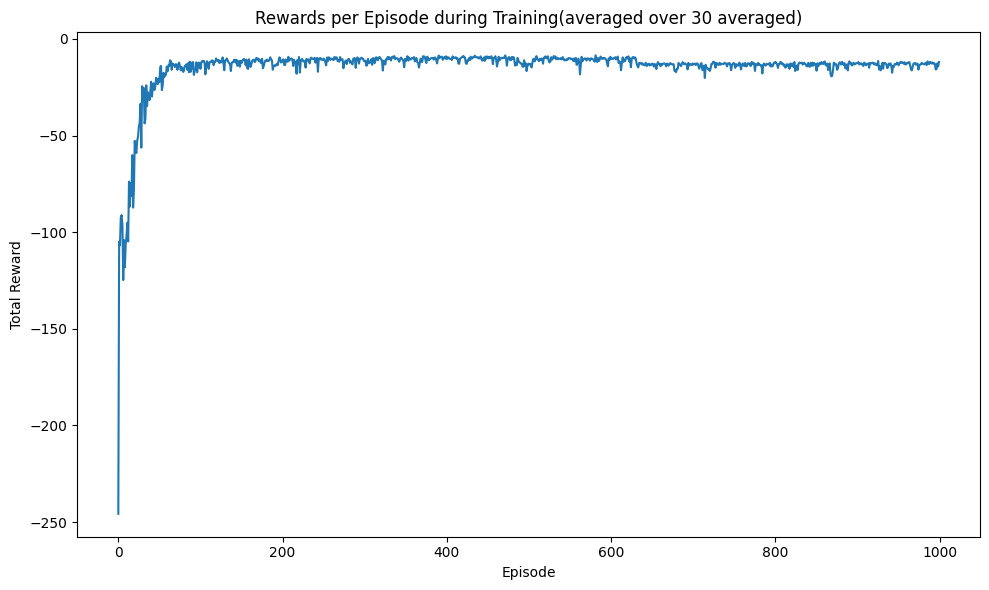

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

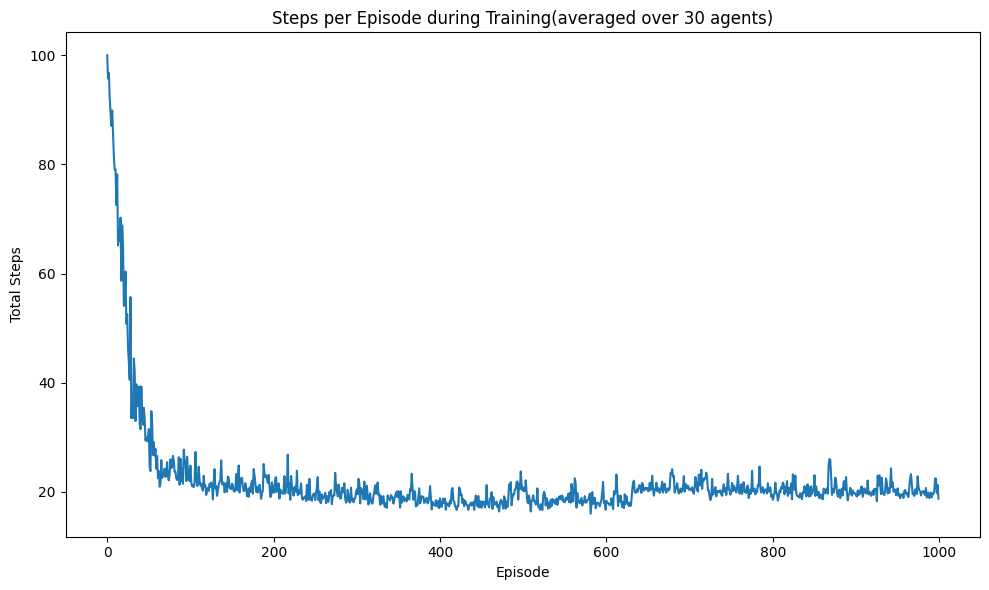

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

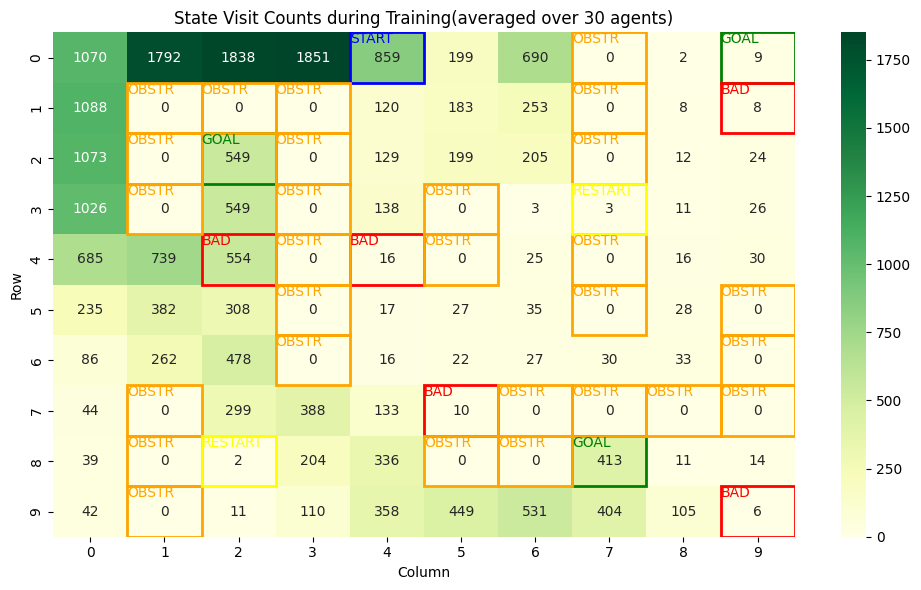

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

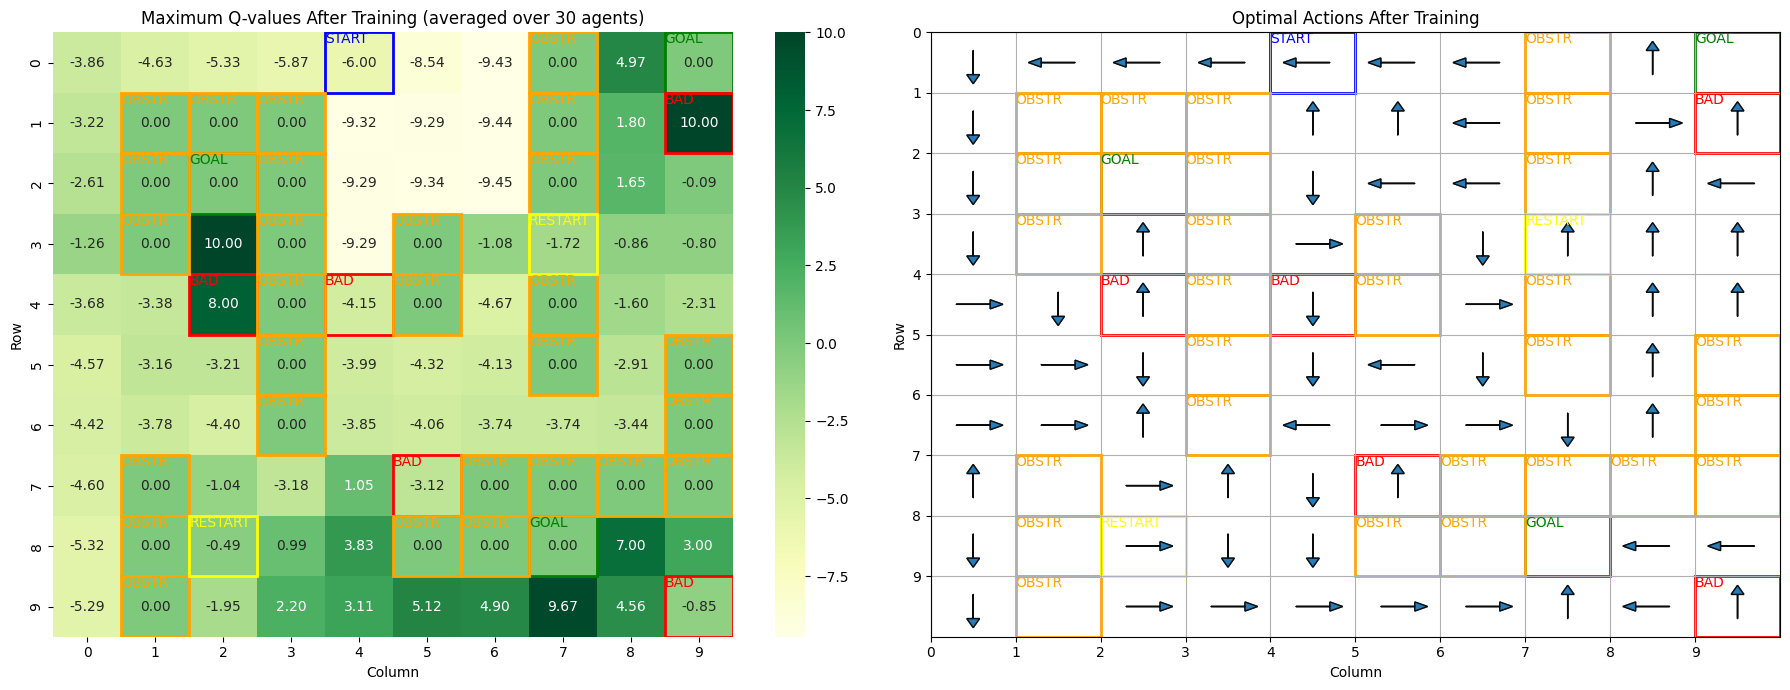

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (2) Configuration id 2


#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [15:08<00:00, 14.20s/it] 


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 1.0
exploration_parameter: 0.001
Mean reward using best hyperparameters: -11.487666666666666
Standard deviation of reward using best hyperparameters: 16.48349359881643


1. Plot reward curves (during the training phase with the best hyperparameters).

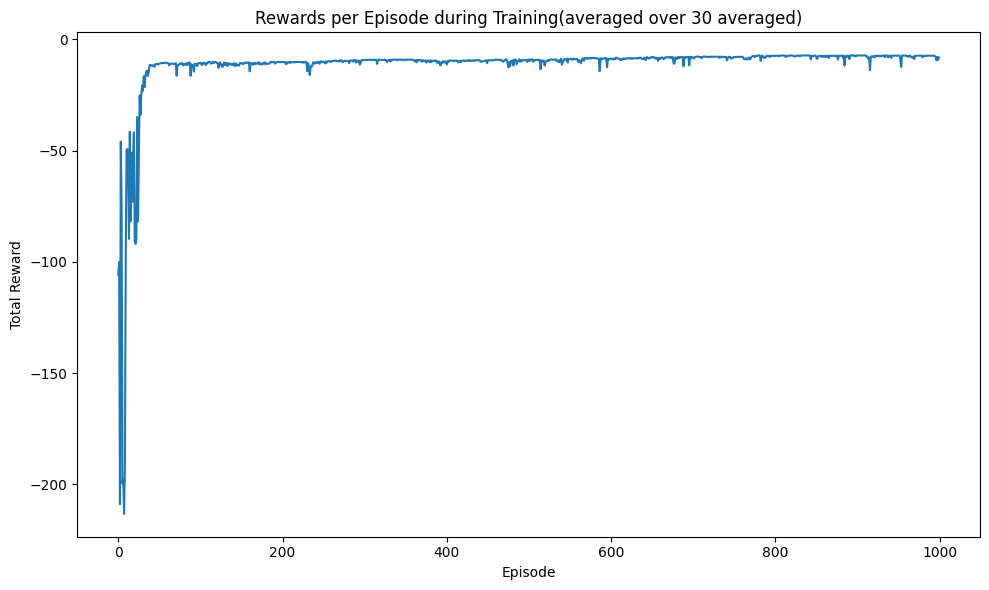

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

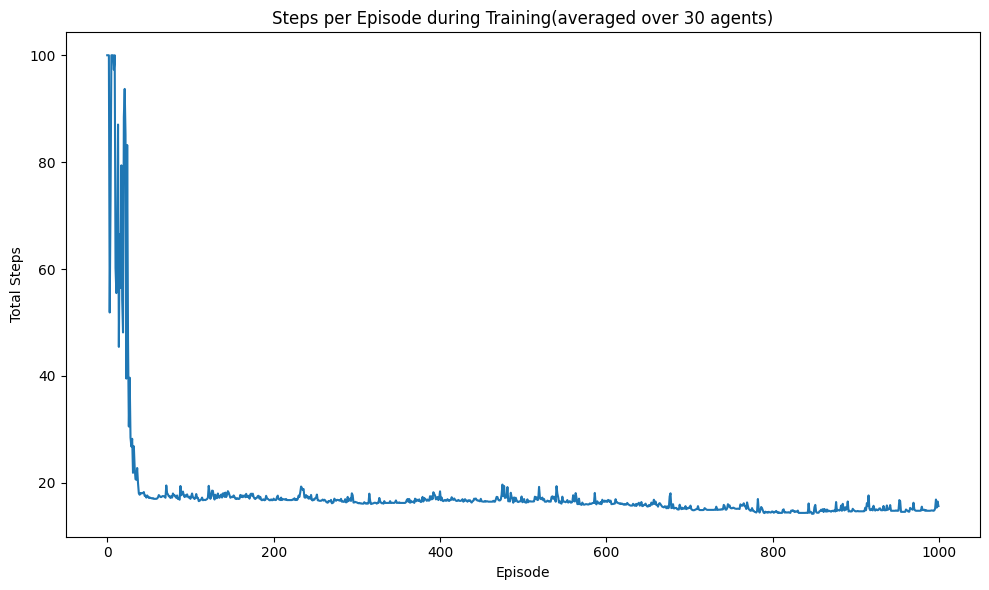

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

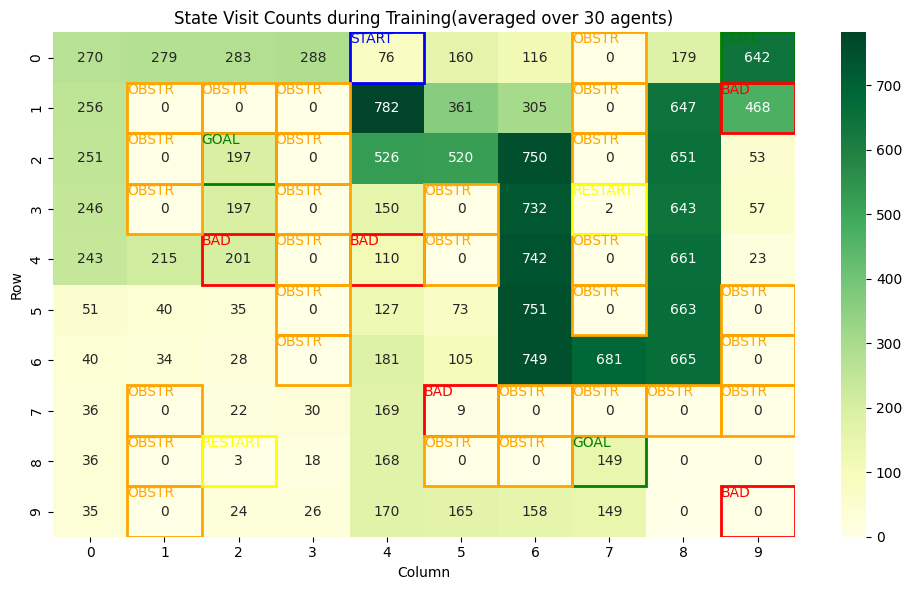

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

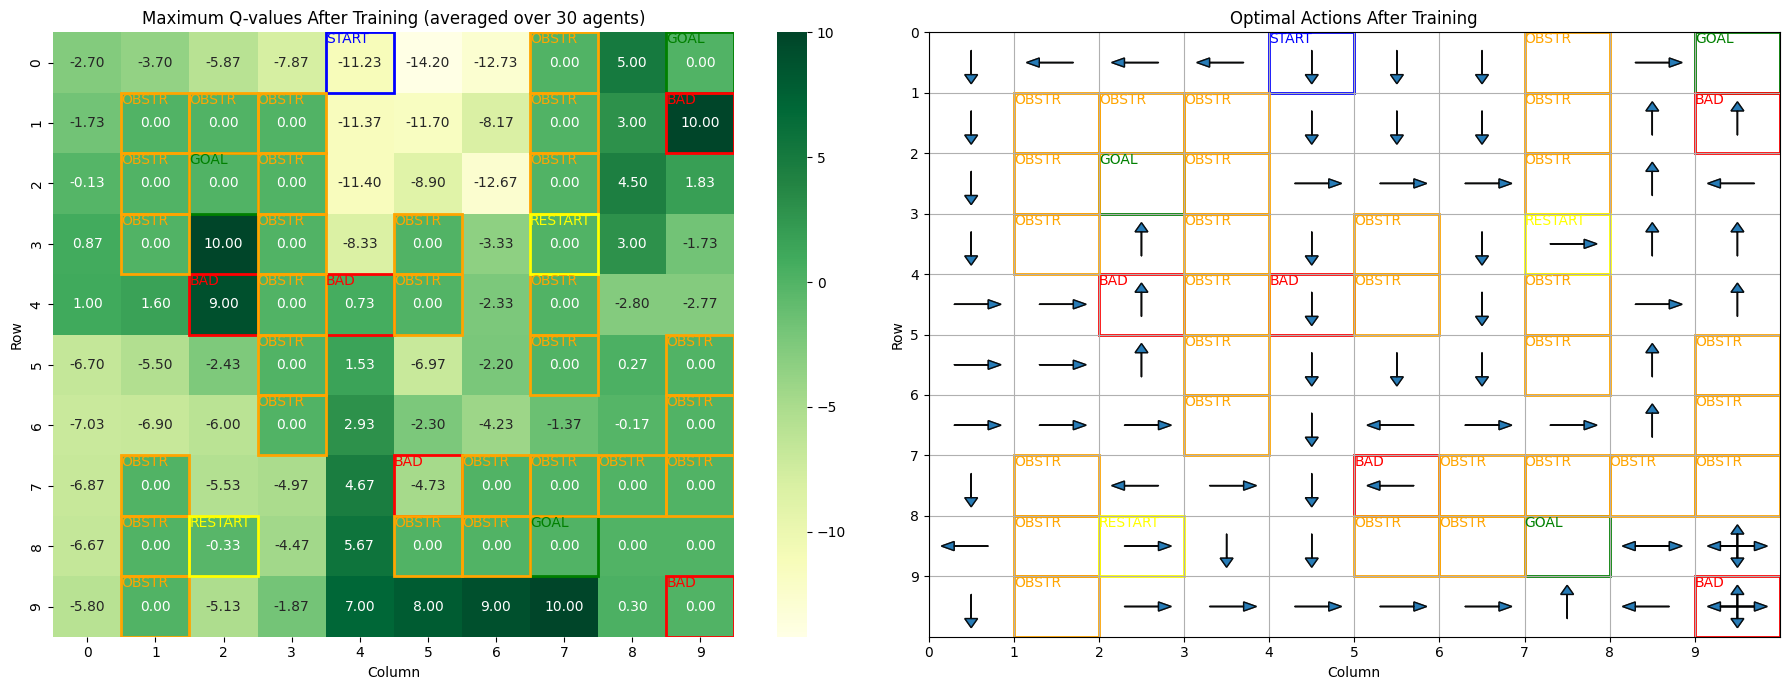

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (3) Configuration id 3

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=True, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [15:34<00:00, 14.60s/it] 


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 1.0
exploration_parameter: 0.001
Mean reward using best hyperparameters: -9.9115
Standard deviation of reward using best hyperparameters: 20.266835799047556


1. Plot reward curves (during the training phase with the best hyperparameters).

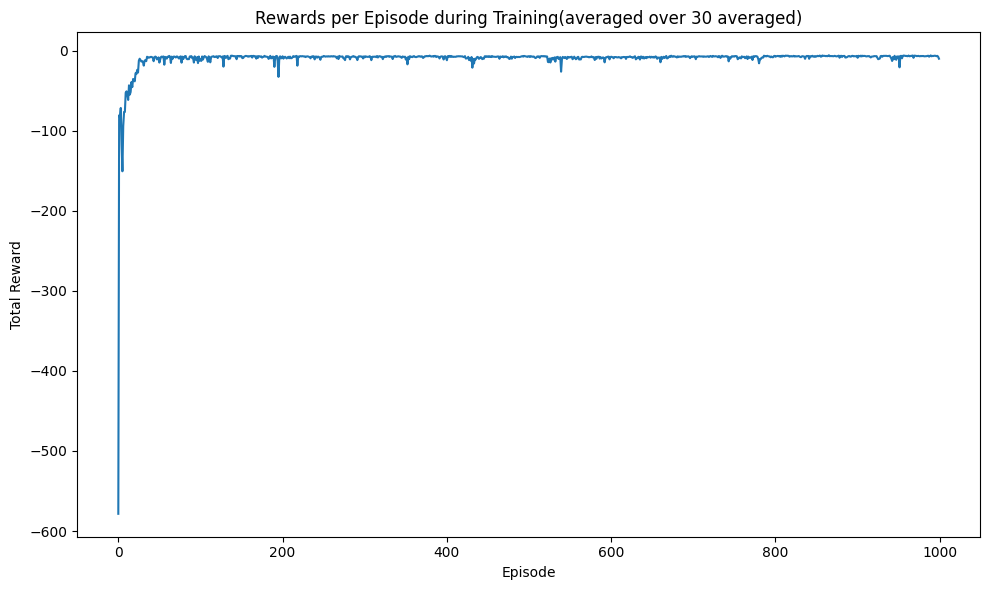

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

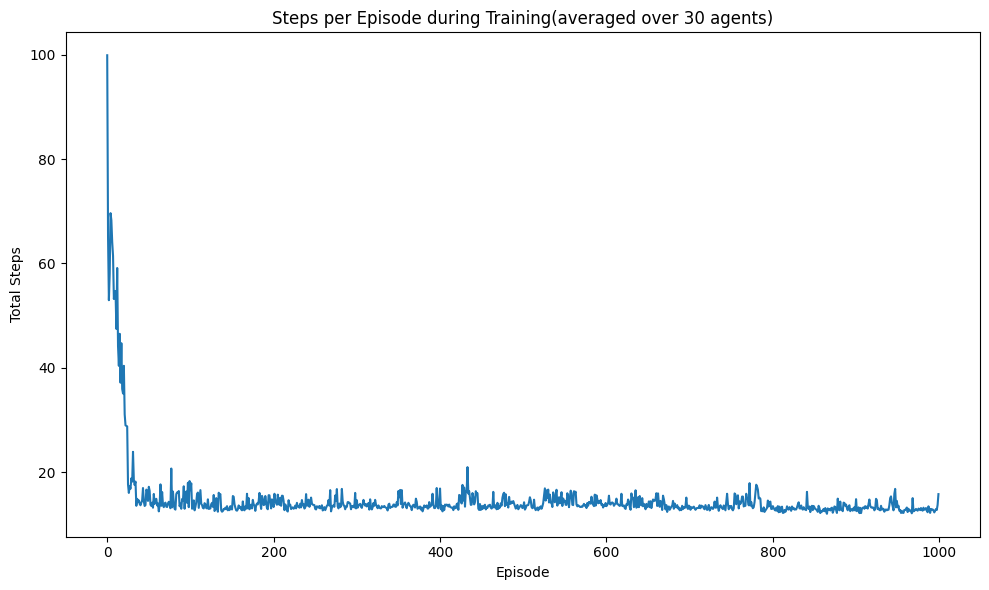

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

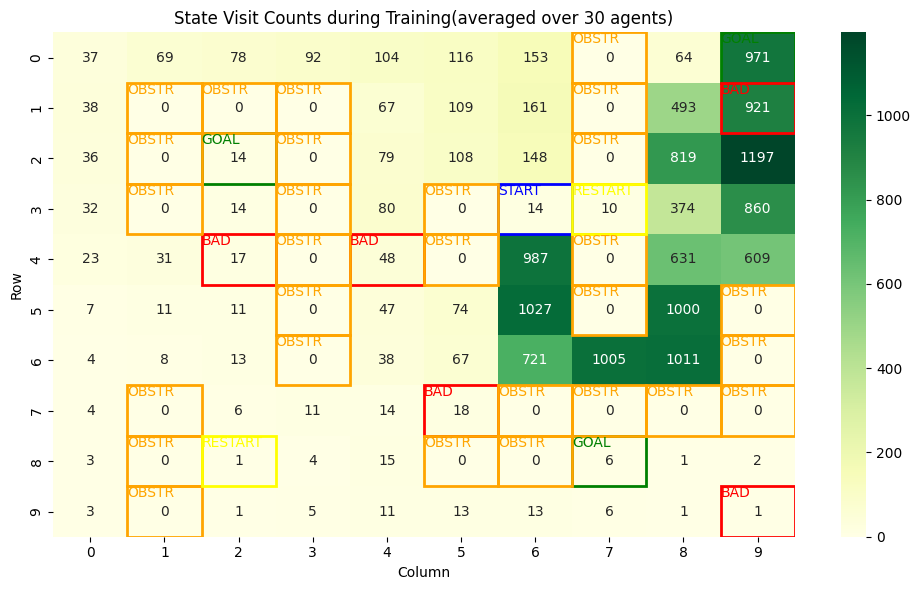

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

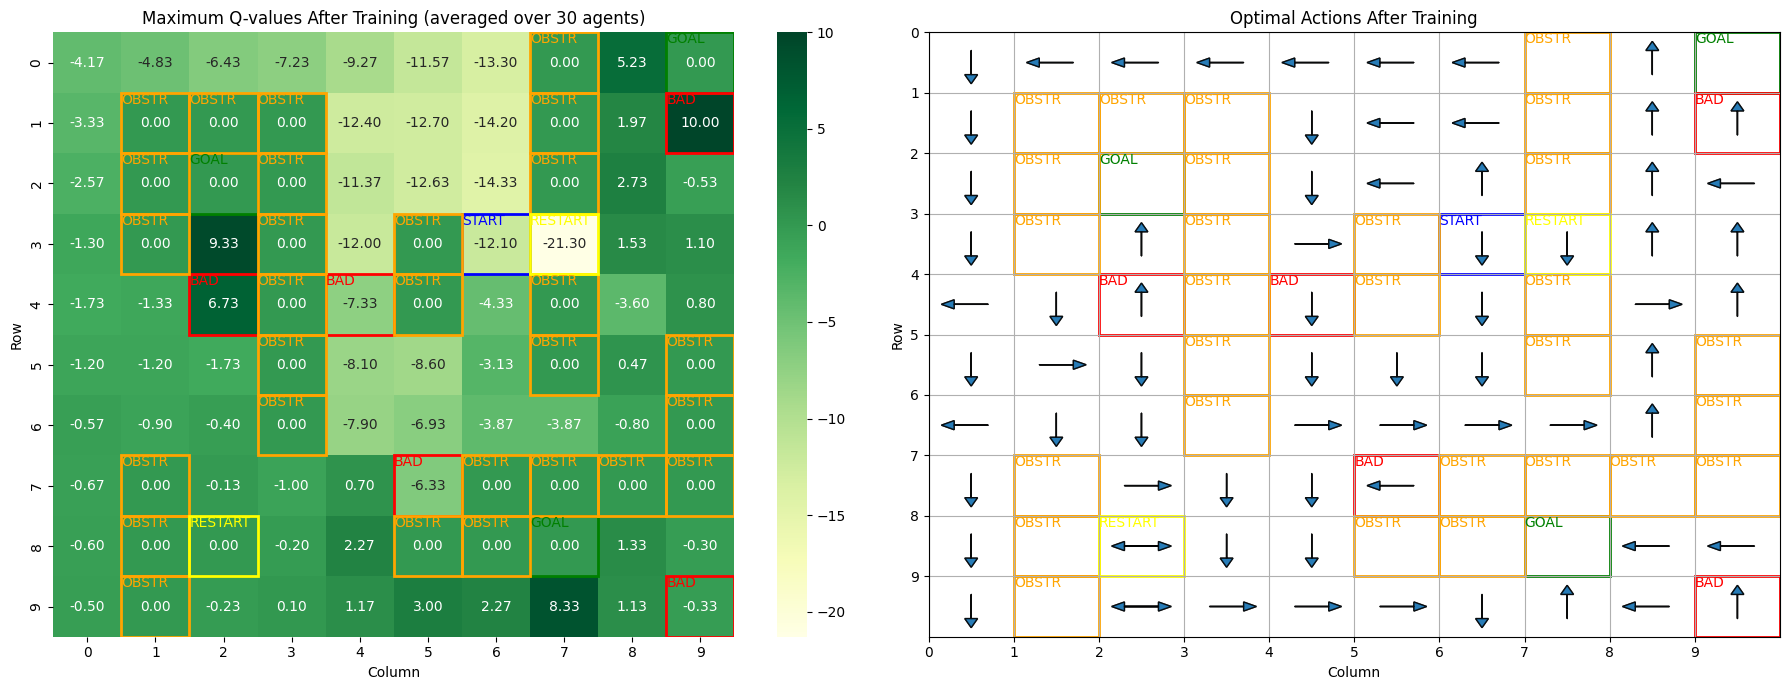

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (4) Configuration id 4

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [14:36<00:00, 13.70s/it] 


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.7
exploration_parameter: 0.001
Mean reward using best hyperparameters: -6.161933333333333
Standard deviation of reward using best hyperparameters: 16.820454407787096


1. Plot reward curves (during the training phase with the best hyperparameters).

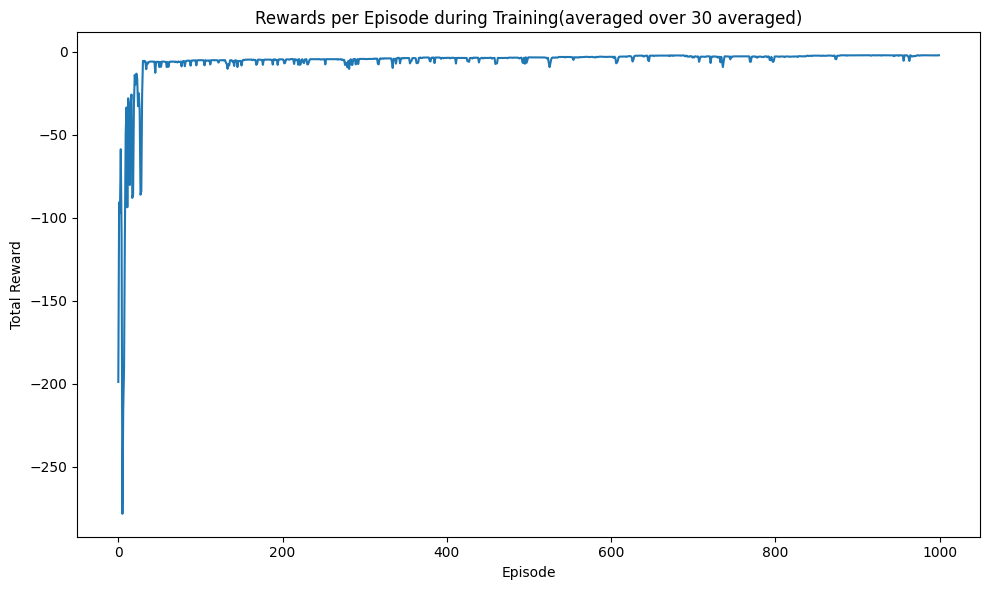

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

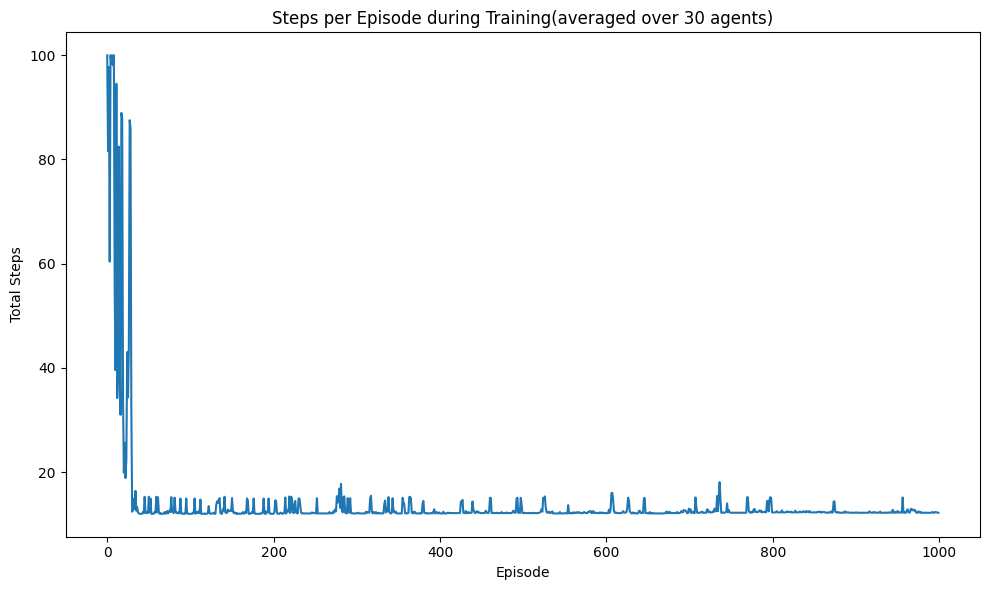

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

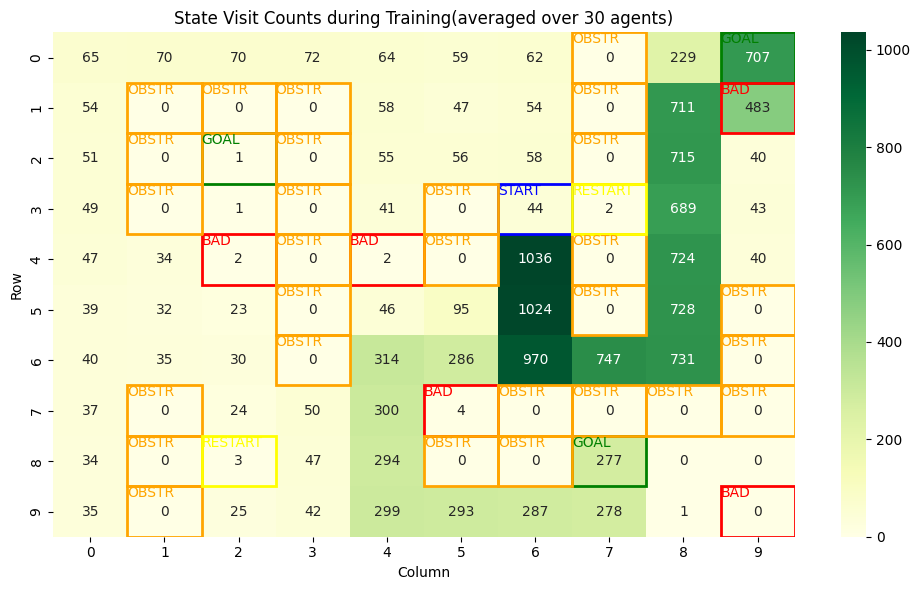

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

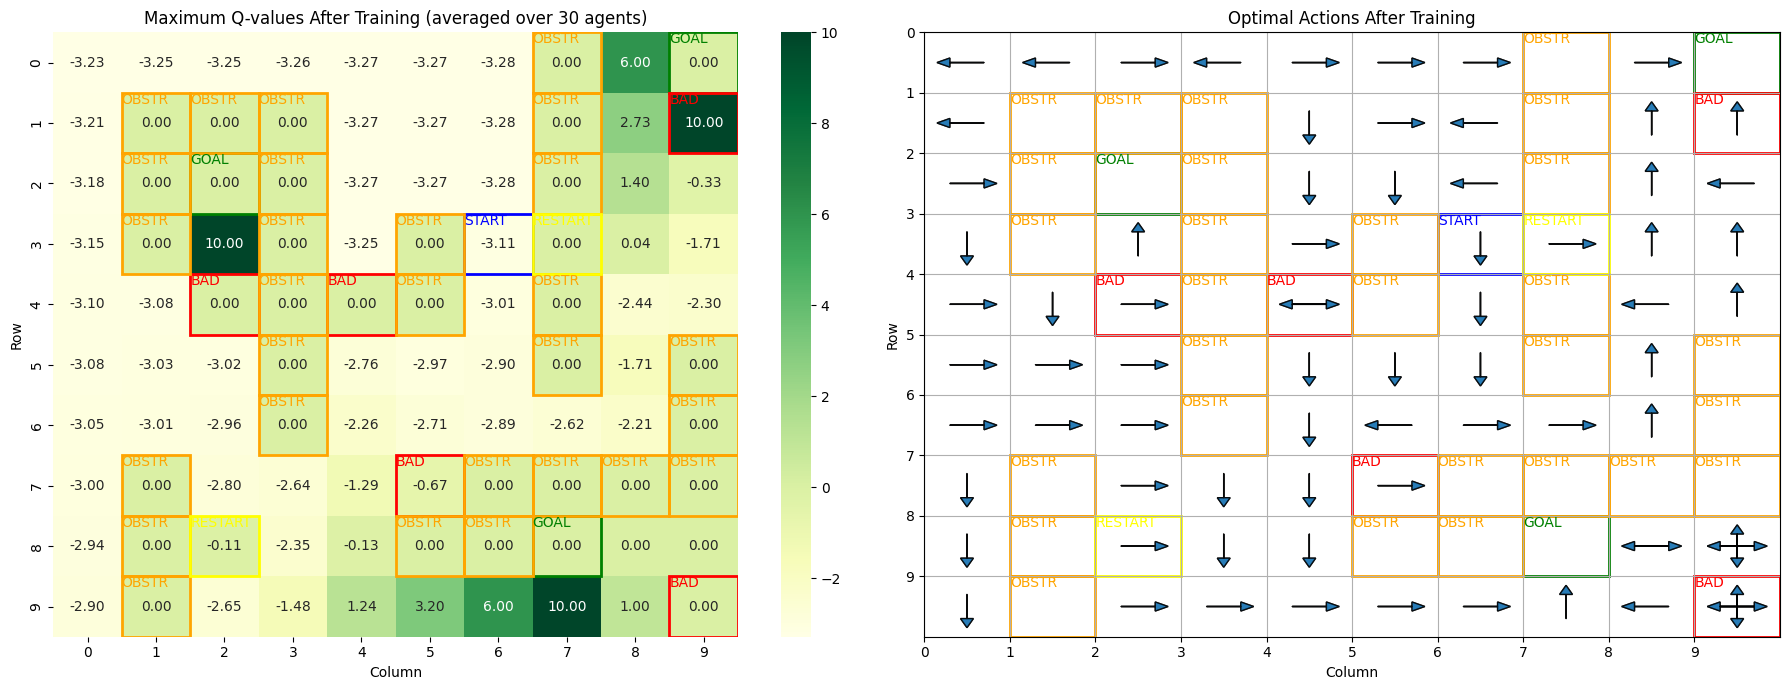

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (5) Configuration id 5

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=True, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [52:02<00:00, 48.79s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 1.0
exploration_parameter: 0.1
Mean reward using best hyperparameters: -12.448366666666665
Standard deviation of reward using best hyperparameters: 15.962291244575969


1. Plot reward curves (during the training phase with the best hyperparameters).

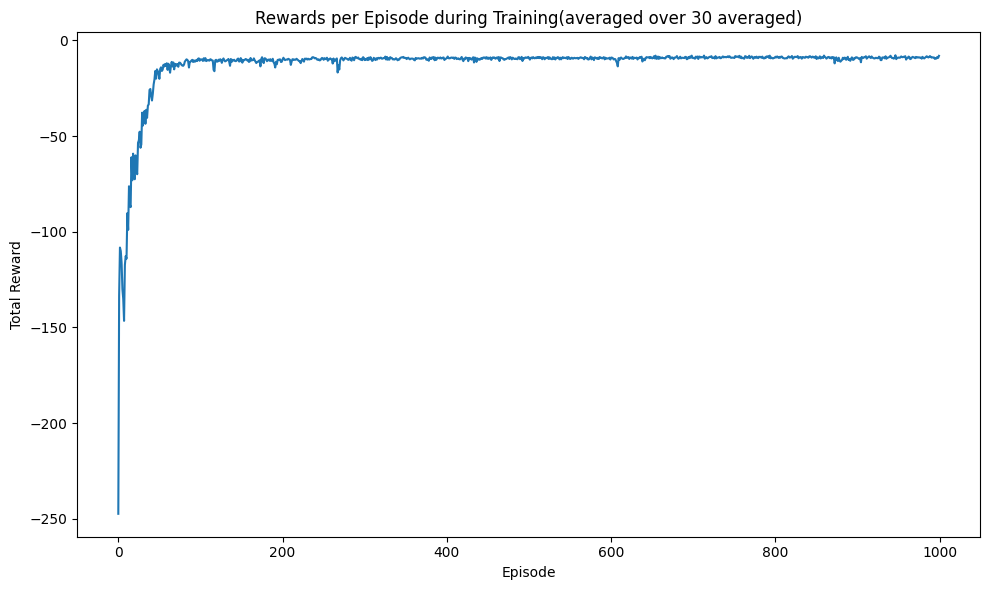

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

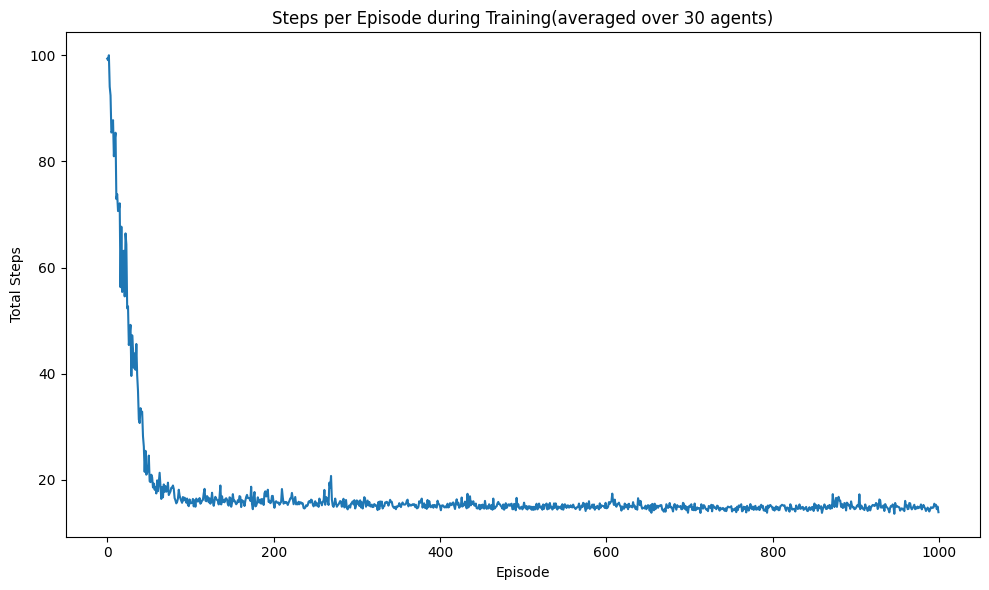

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

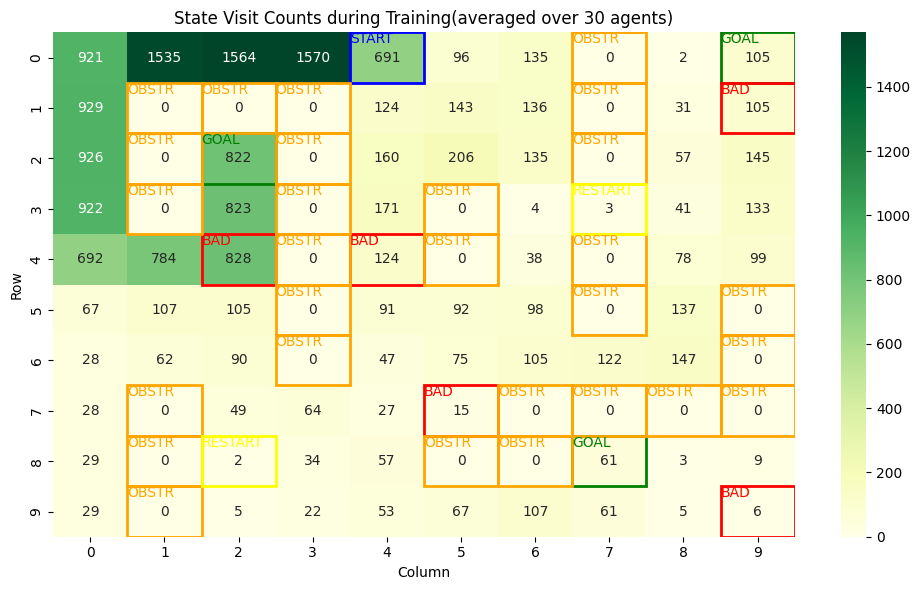

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

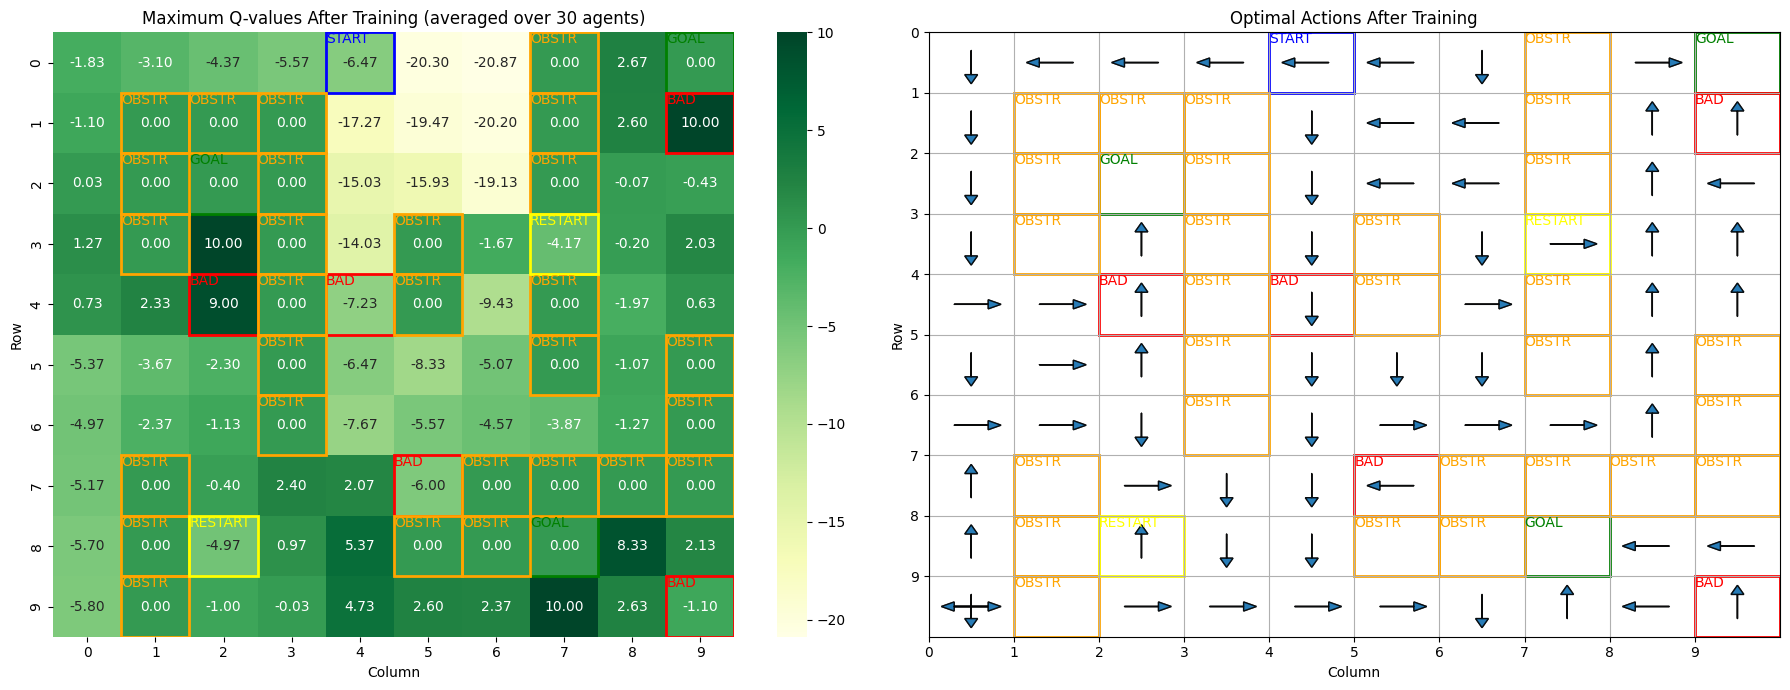

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (6) Configuration id 6

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [44:43<00:00, 41.93s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.9
exploration_parameter: 0.01
Mean reward using best hyperparameters: -9.181833333333334
Standard deviation of reward using best hyperparameters: 15.230971661387859


1. Plot reward curves (during the training phase with the best hyperparameters).

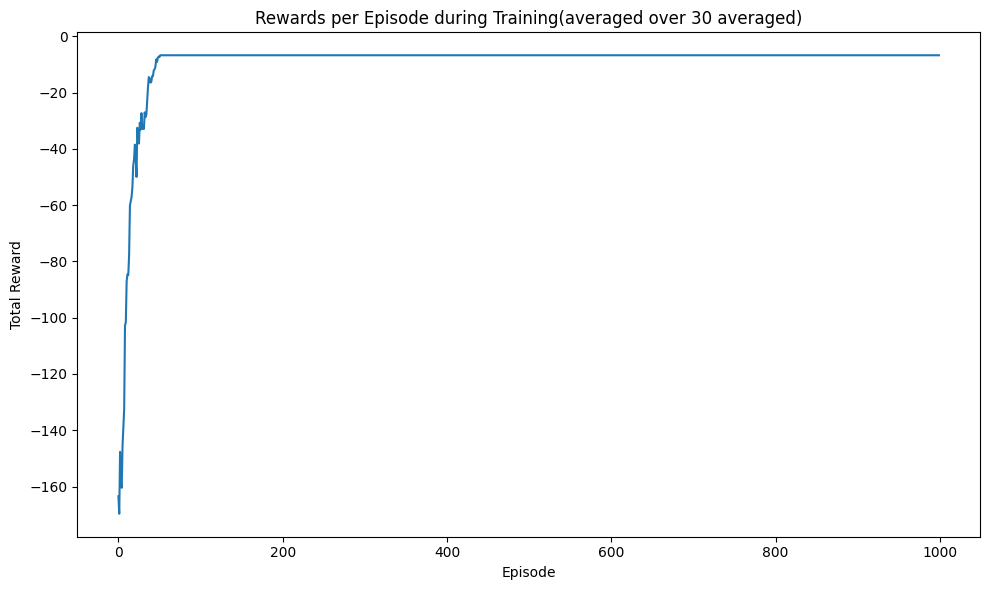

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

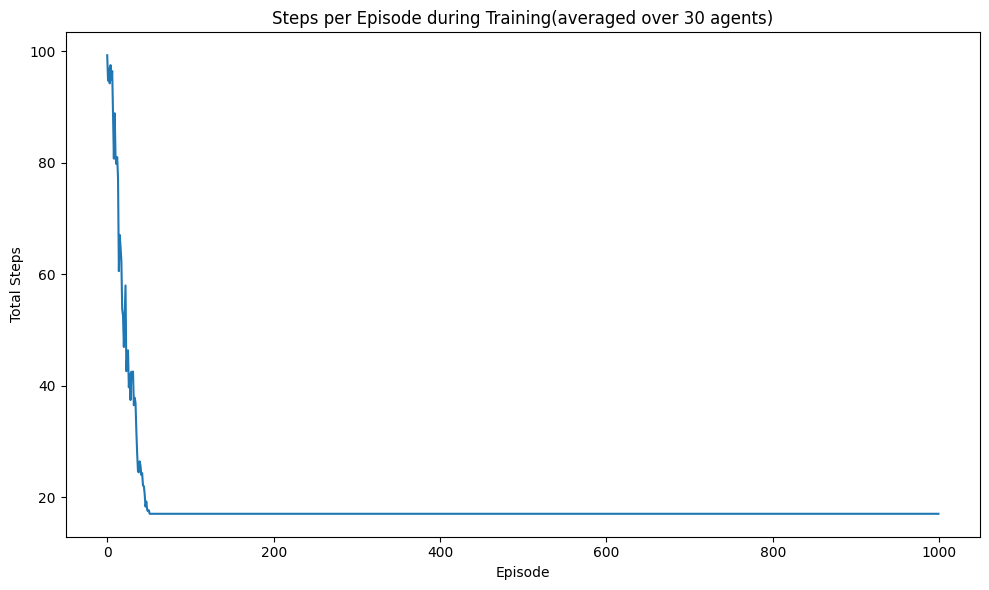

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

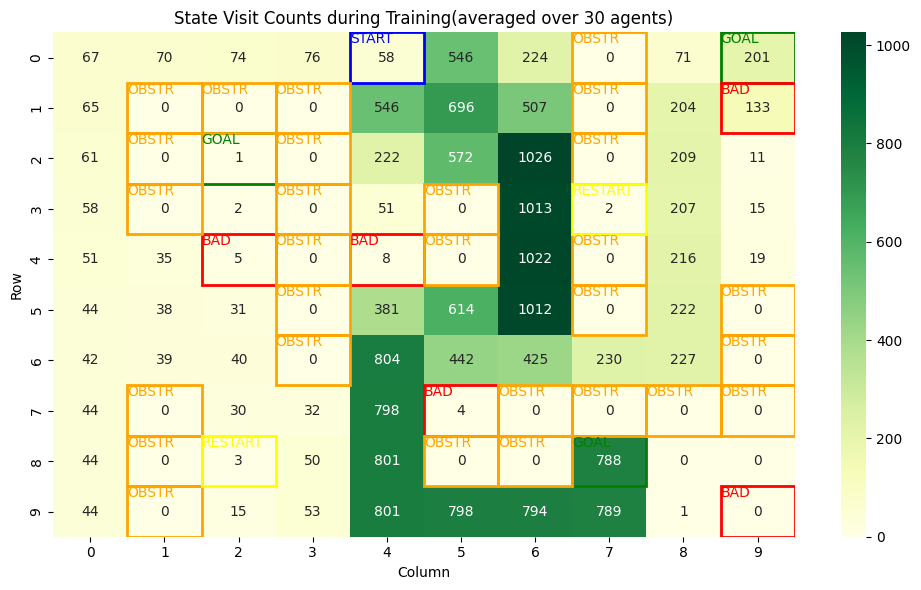

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

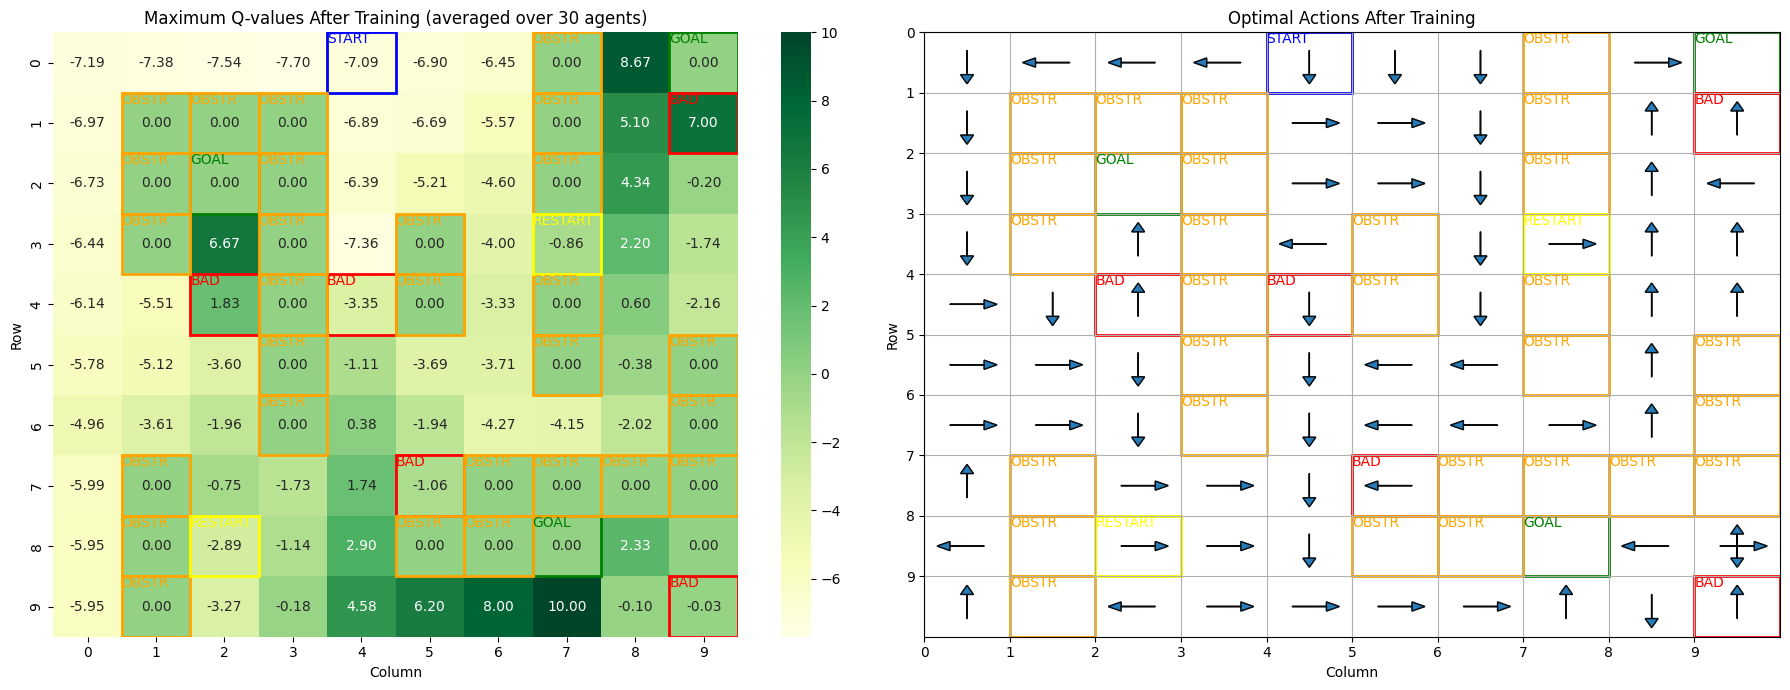

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (7) Configuration id 7

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=True, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [40:47<00:00, 38.24s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 1.0
exploration_parameter: 0.01
Mean reward using best hyperparameters: -7.892433333333332
Standard deviation of reward using best hyperparameters: 20.12776499904216


1. Plot reward curves (during the training phase with the best hyperparameters).

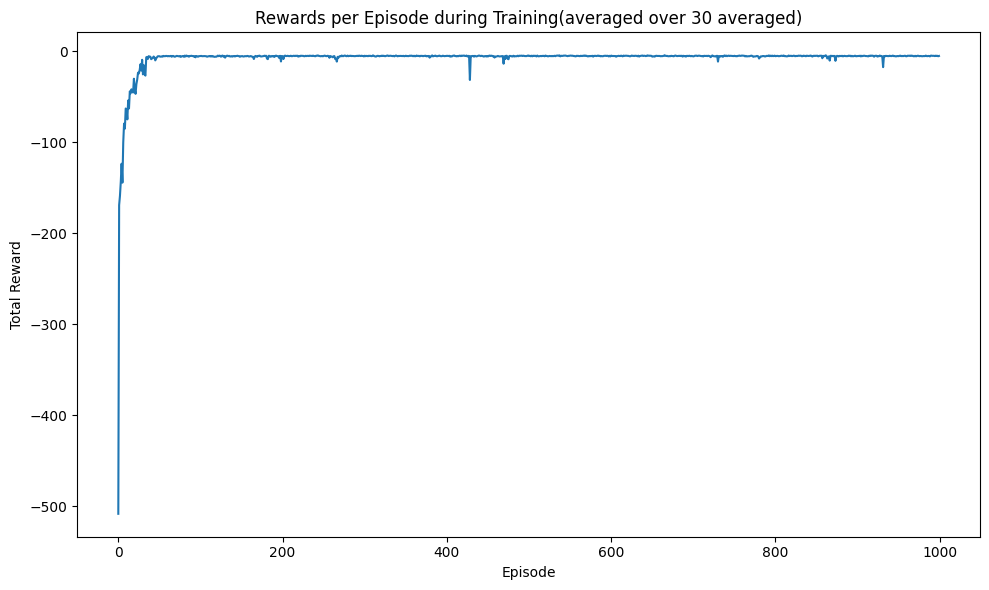

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

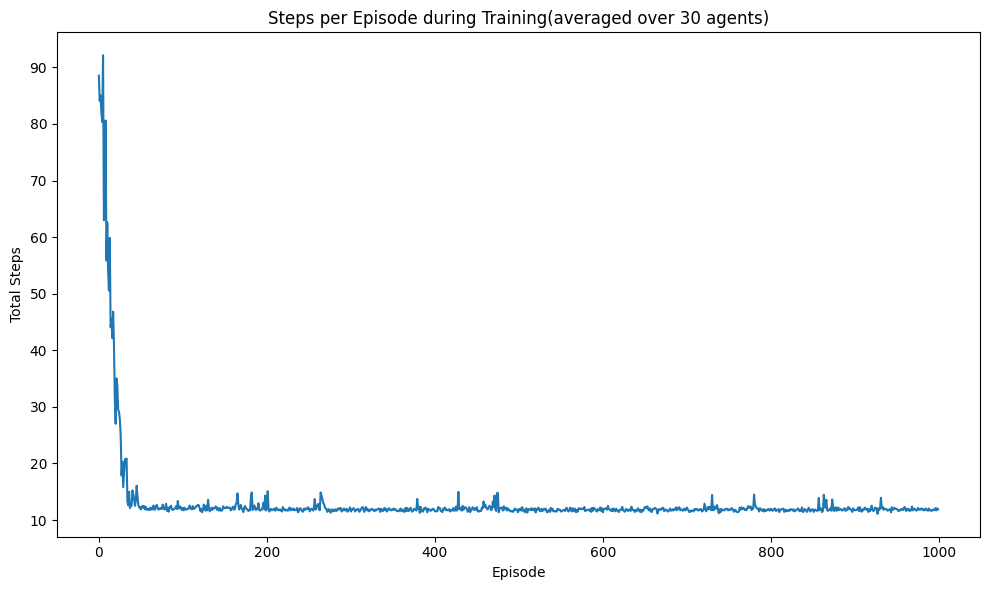

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

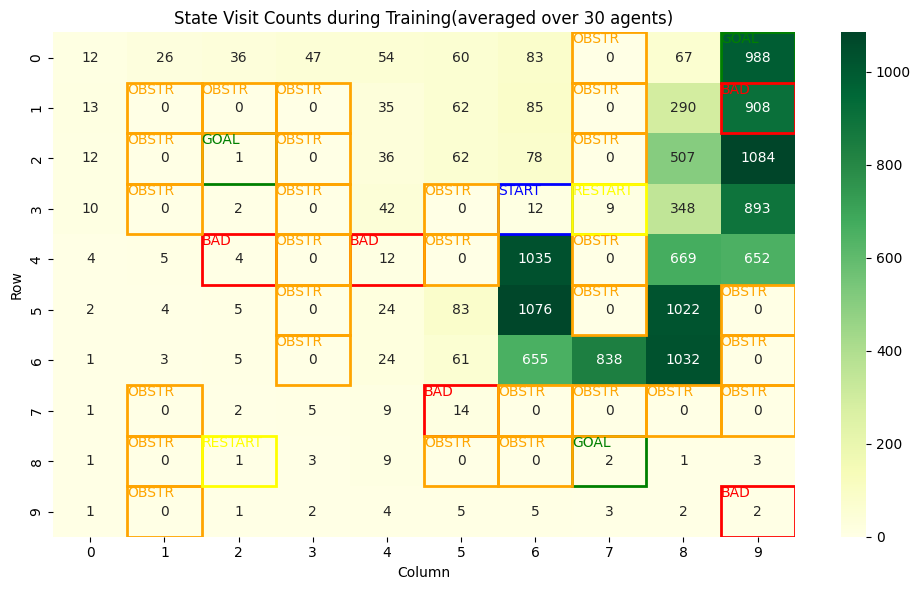

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

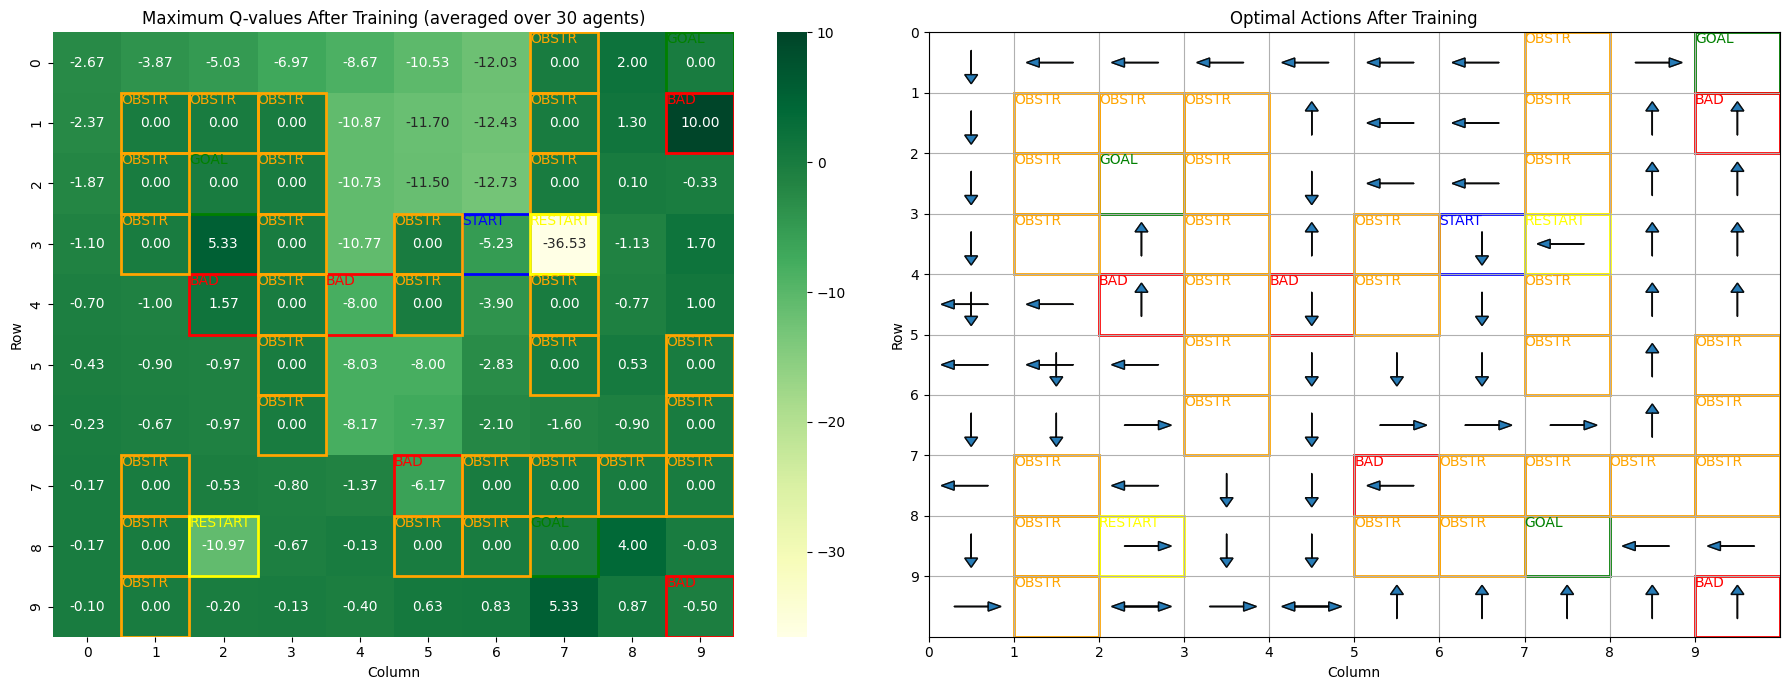

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (8) Configuration id 8

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=sarsa)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")

print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [41:22<00:00, 38.79s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.8
exploration_parameter: 0.1
Mean reward using best hyperparameters: -3.5187333333333335
Standard deviation of reward using best hyperparameters: 15.5369036725111


1. Plot reward curves (during the training phase with the best hyperparameters).

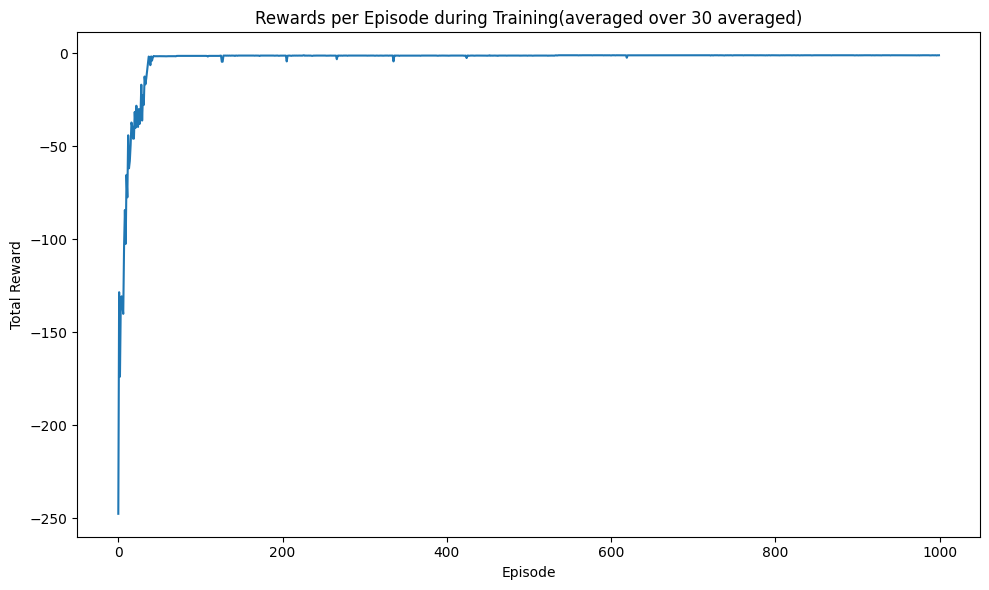

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

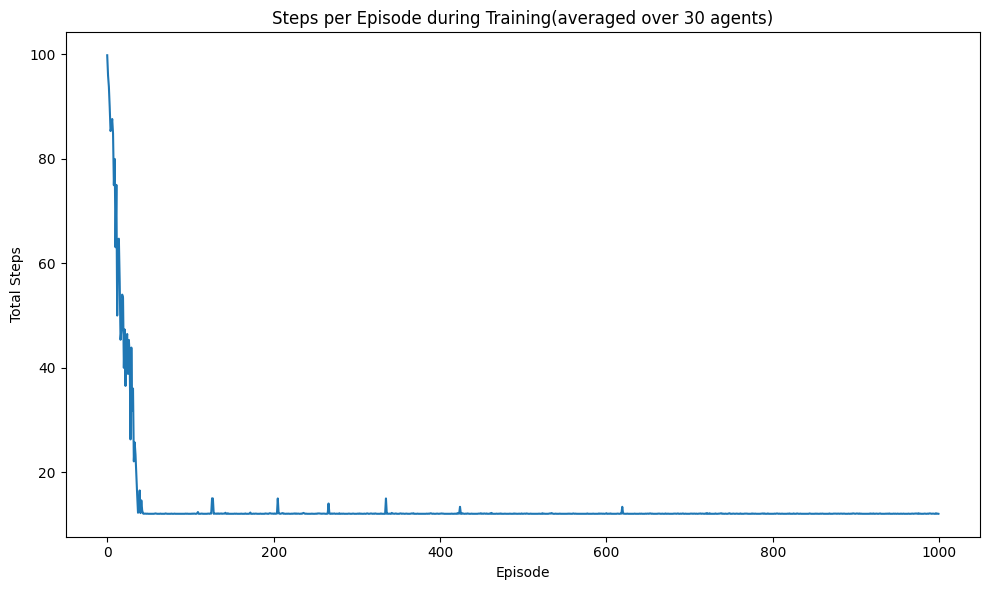

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

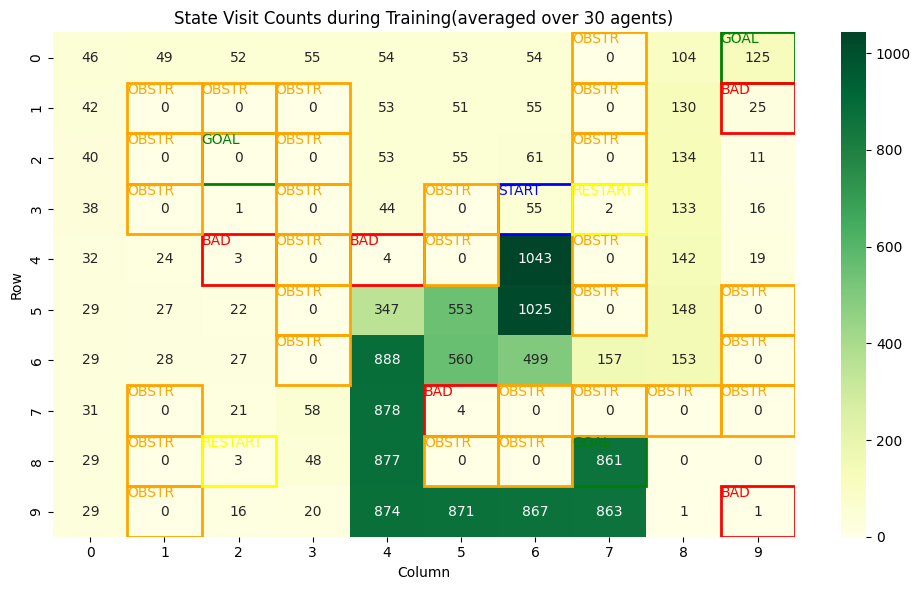

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

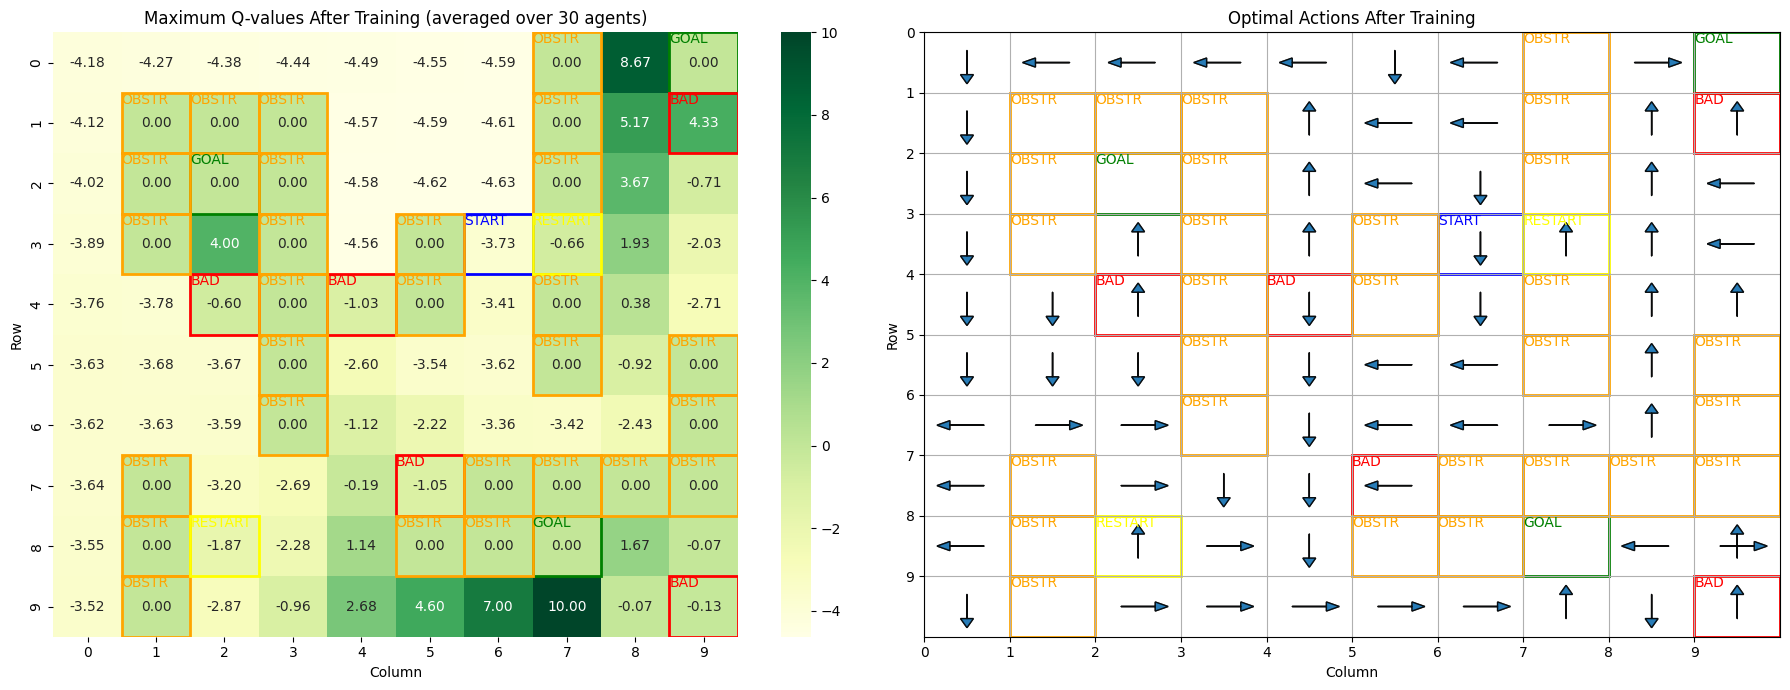

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

## Q-learning

In [ ]:
def qlearning(env, learning_rate, discount_factor, strategy, parameter, num_episodes=1000, max_steps=100):

    """Q-learning algorithm implementation."""

    # Initialize Q-values
    Q = np.zeros((env.num_states, env.num_actions))

    # Statistics
    num_visits = np.zeros(env.num_states)
    rewards_per_episode = []
    steps_per_episode = []

    for episode in range(num_episodes):

        state_current = env.reset()
        episode_reward = 0
        episode_steps = 0

        for step in range(max_steps):

            # Choose action based on current state
            action = strategy(parameter, Q[state_current])

            # Take action and observe next state and reward
            state_next, reward = env.step(state_current, action)

            reward = reward[0]

            # Update the statistics
            episode_reward += reward
            episode_steps += 1
            num_visits[state_next] += 1

            # Update Q-value
            Q[state_current, action] += learning_rate * (
                reward + discount_factor * np.max(Q[state_next]) - Q[state_current, action]
            )

            # Check if goal reached
            if state_next in env.goal_states_seq:
                break

            # Move to next state
            state_current = state_next

        rewards_per_episode.append(episode_reward)
        steps_per_episode.append(episode_steps)

    return Q, rewards_per_episode, steps_per_episode, num_visits

### (1) Configuration id 9

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [16:31<00:00, 15.49s/it] 


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.7
exploration_parameter: 0.01
Mean reward using best hyperparameters: -10.676966666666667
Standard deviation of reward using best hyperparameters: 15.744831868796398


1. Plot reward curves (during the training phase with the best hyperparameters).

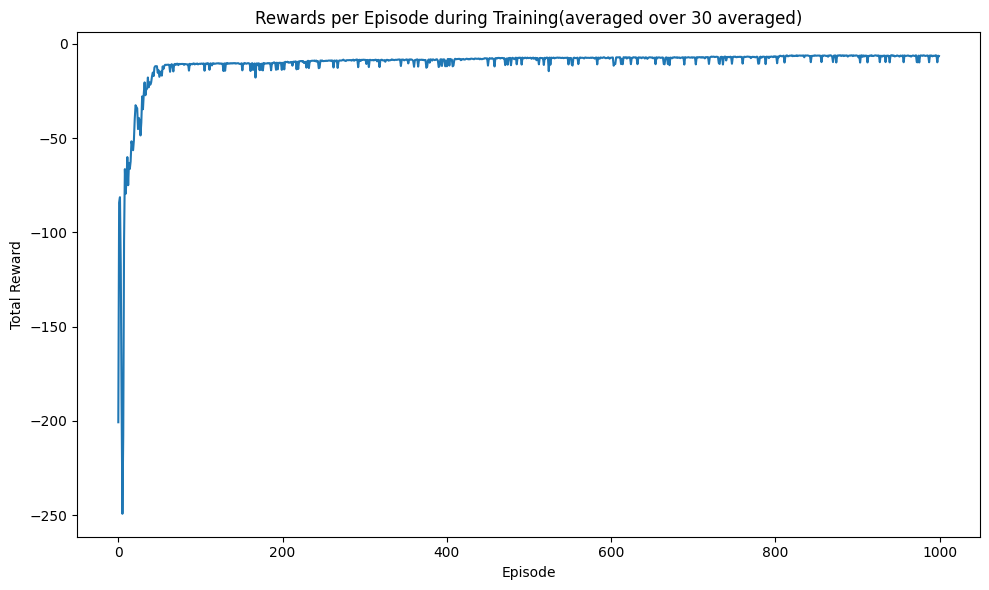

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

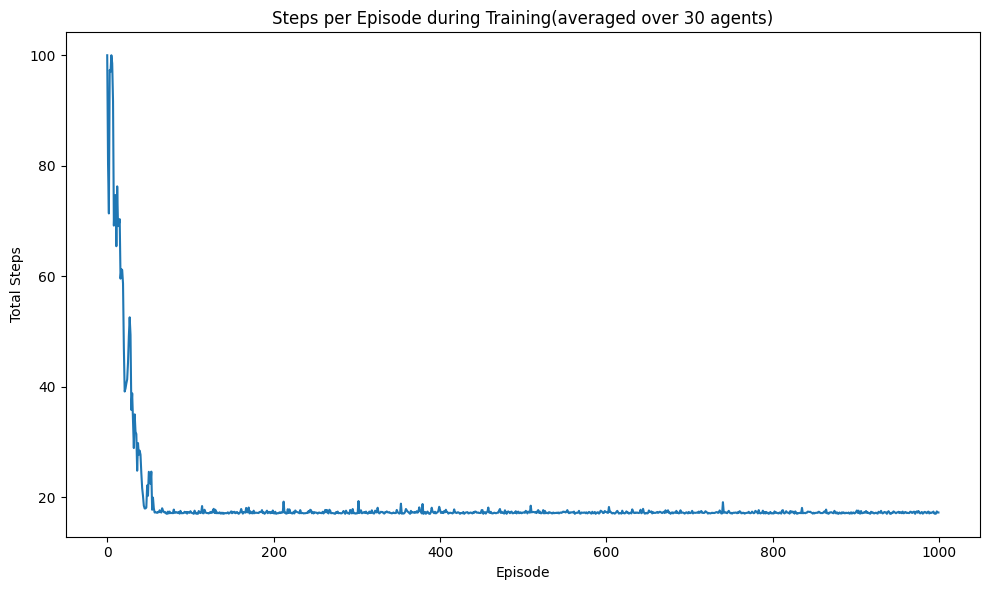

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

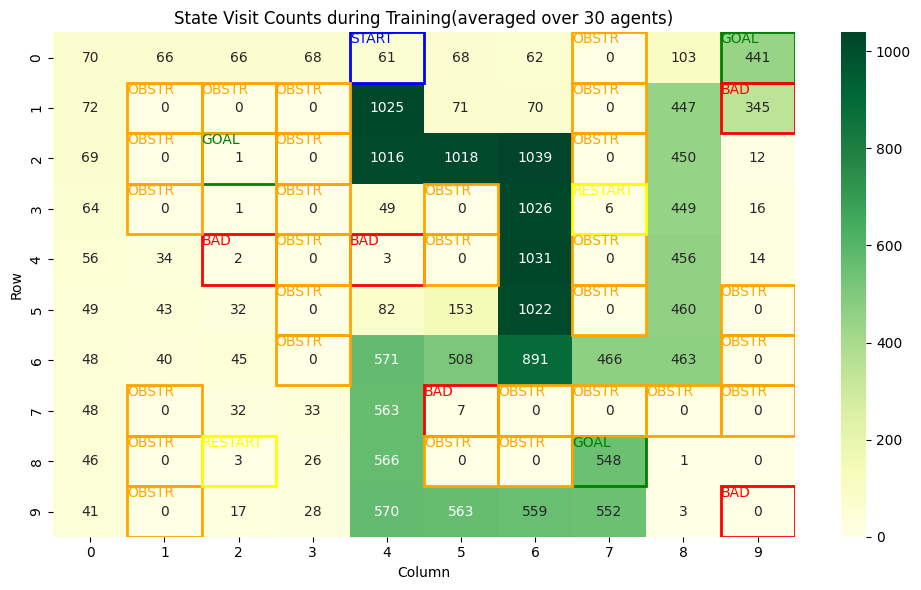

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

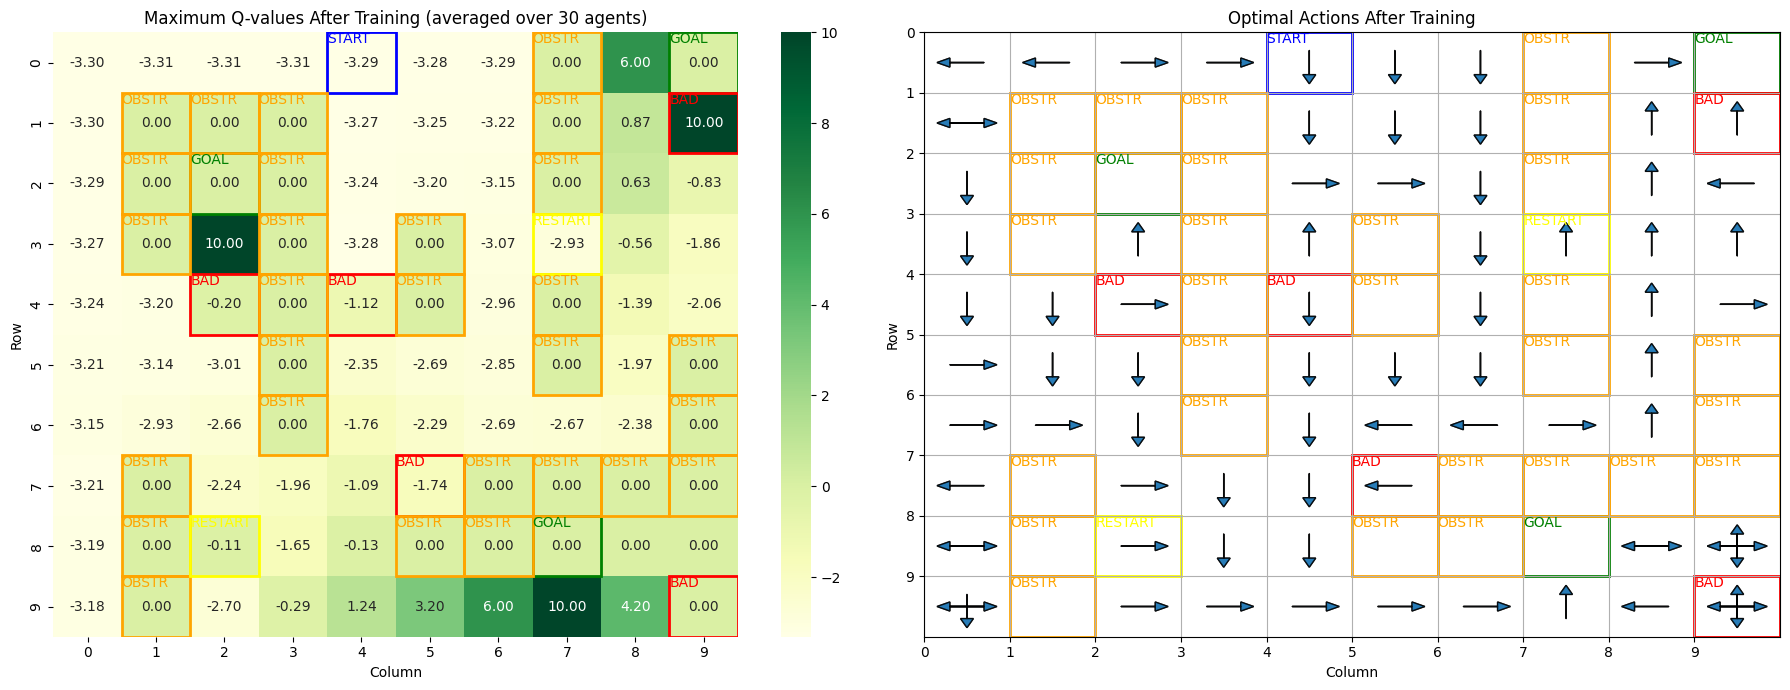

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (2) Configuration id 10

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [15:48<00:00, 14.82s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.7
exploration_parameter: 0.01
Mean reward using best hyperparameters: -5.943433333333334
Standard deviation of reward using best hyperparameters: 15.959554268037827


1. Plot reward curves (during the training phase with the best hyperparameters).

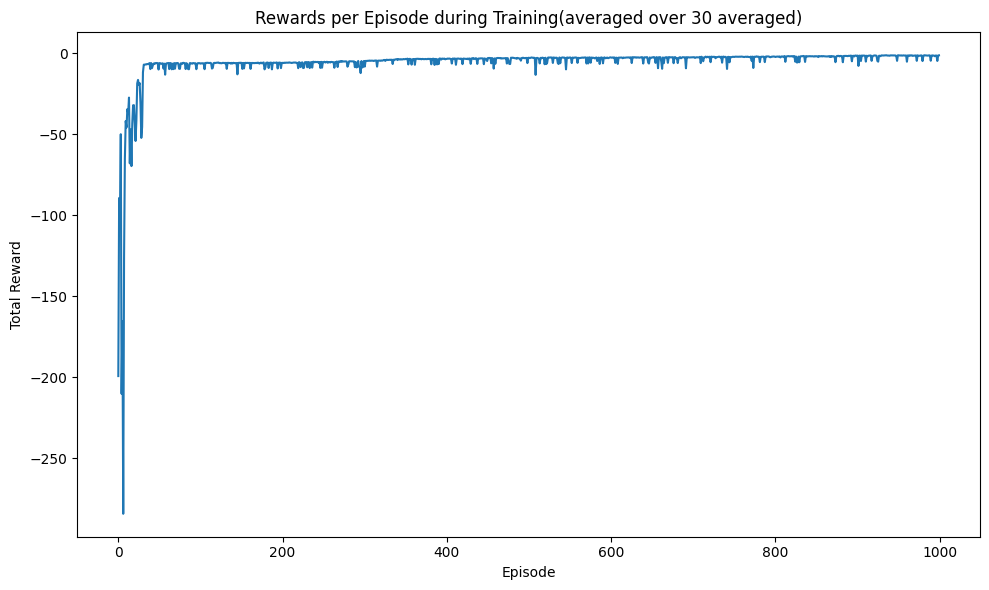

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

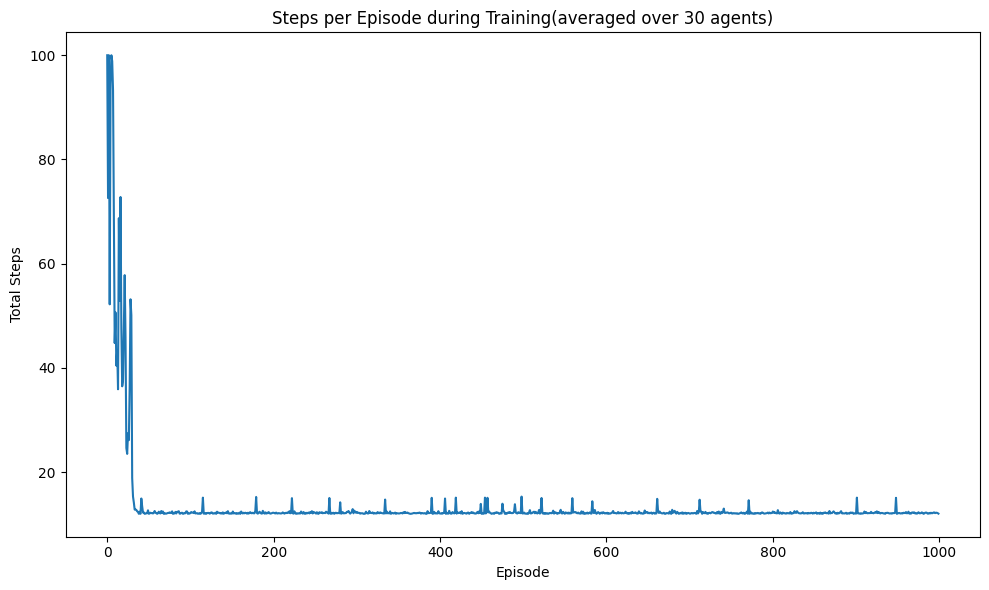

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

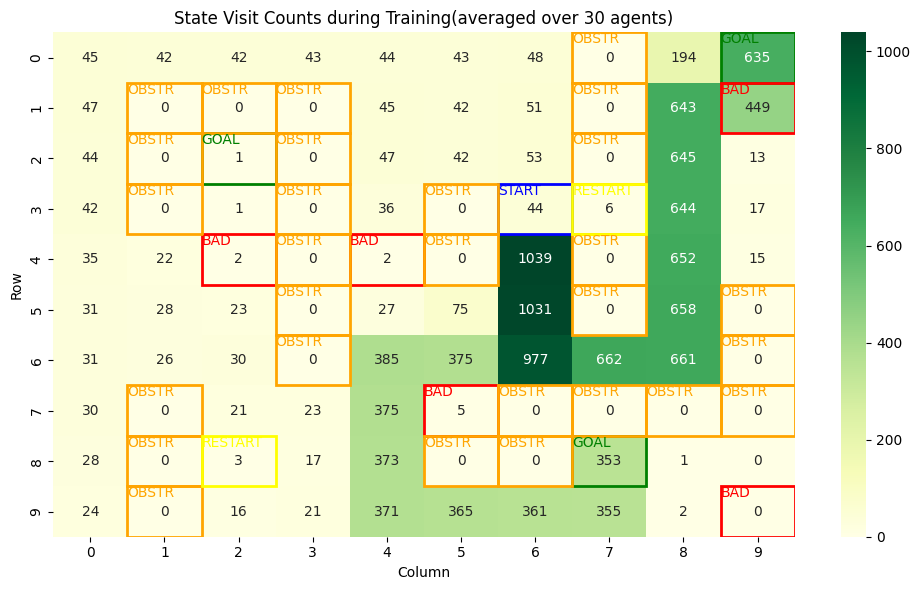

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

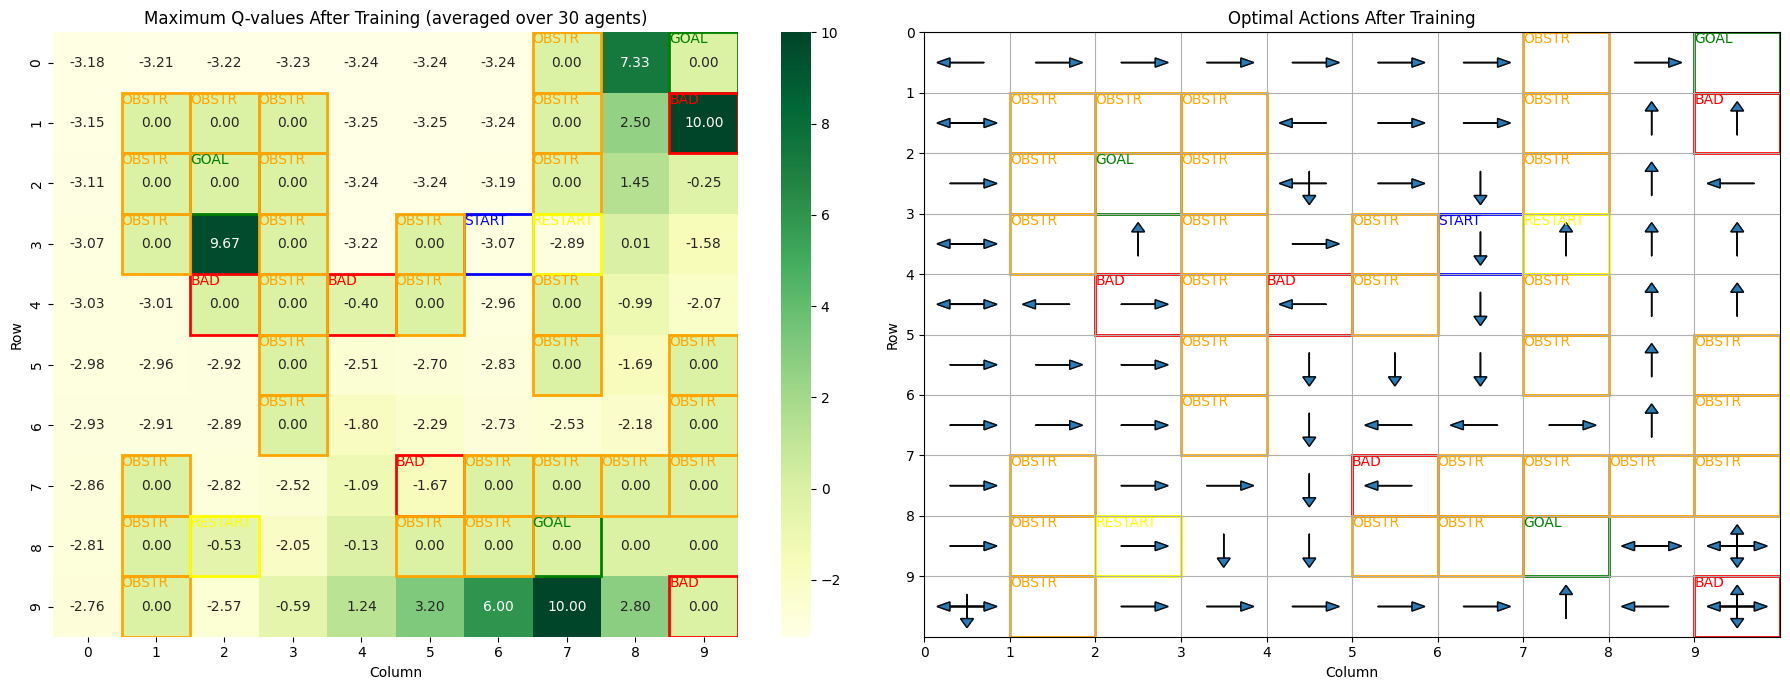

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (3) Configuration id 11

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=False, p=0.7)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [21:46<00:00, 20.42s/it] 


Best hyperparameters are:
learning_rate: 0.1
discount_factor: 1.0
exploration_parameter: 0.001
Mean reward using best hyperparameters: -32.438
Standard deviation of reward using best hyperparameters: 31.616904943751564


1. Plot reward curves (during the training phase with the best hyperparameters).

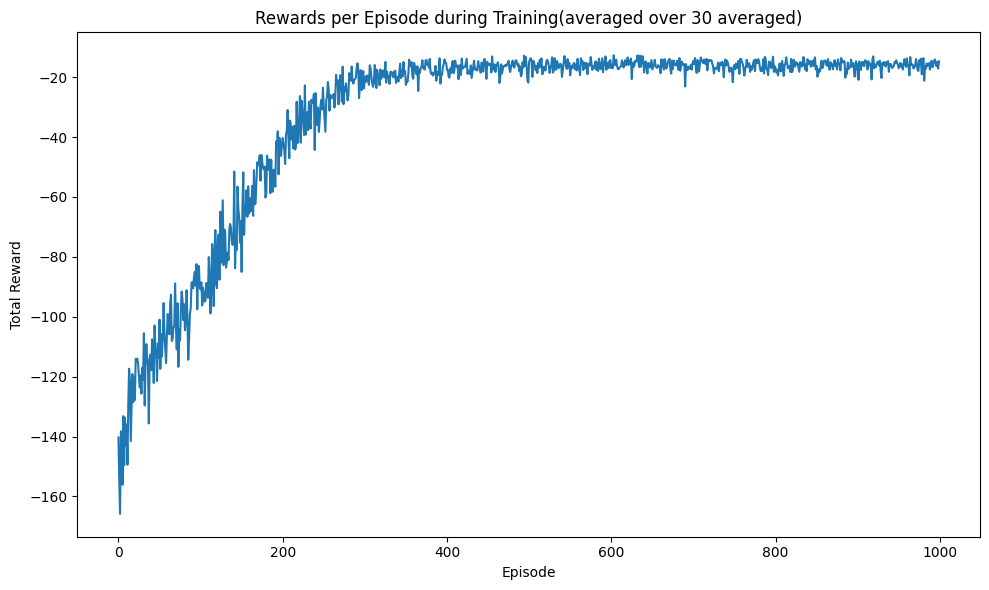

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

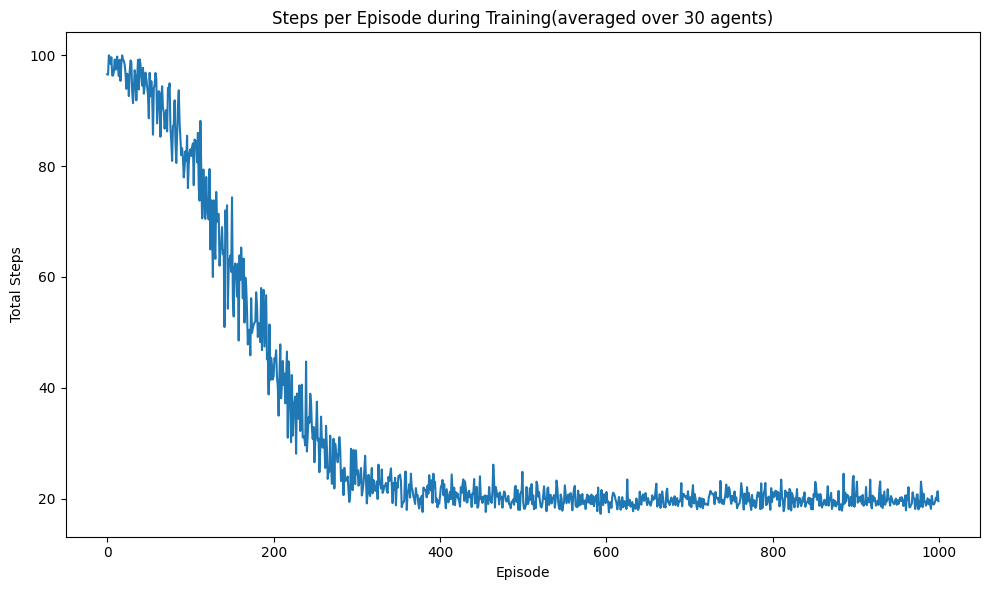

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

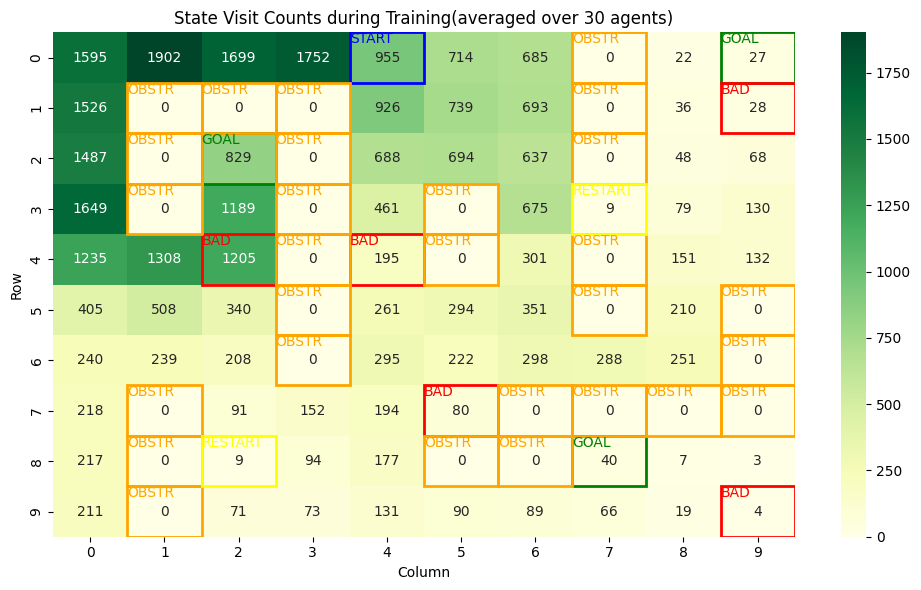

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

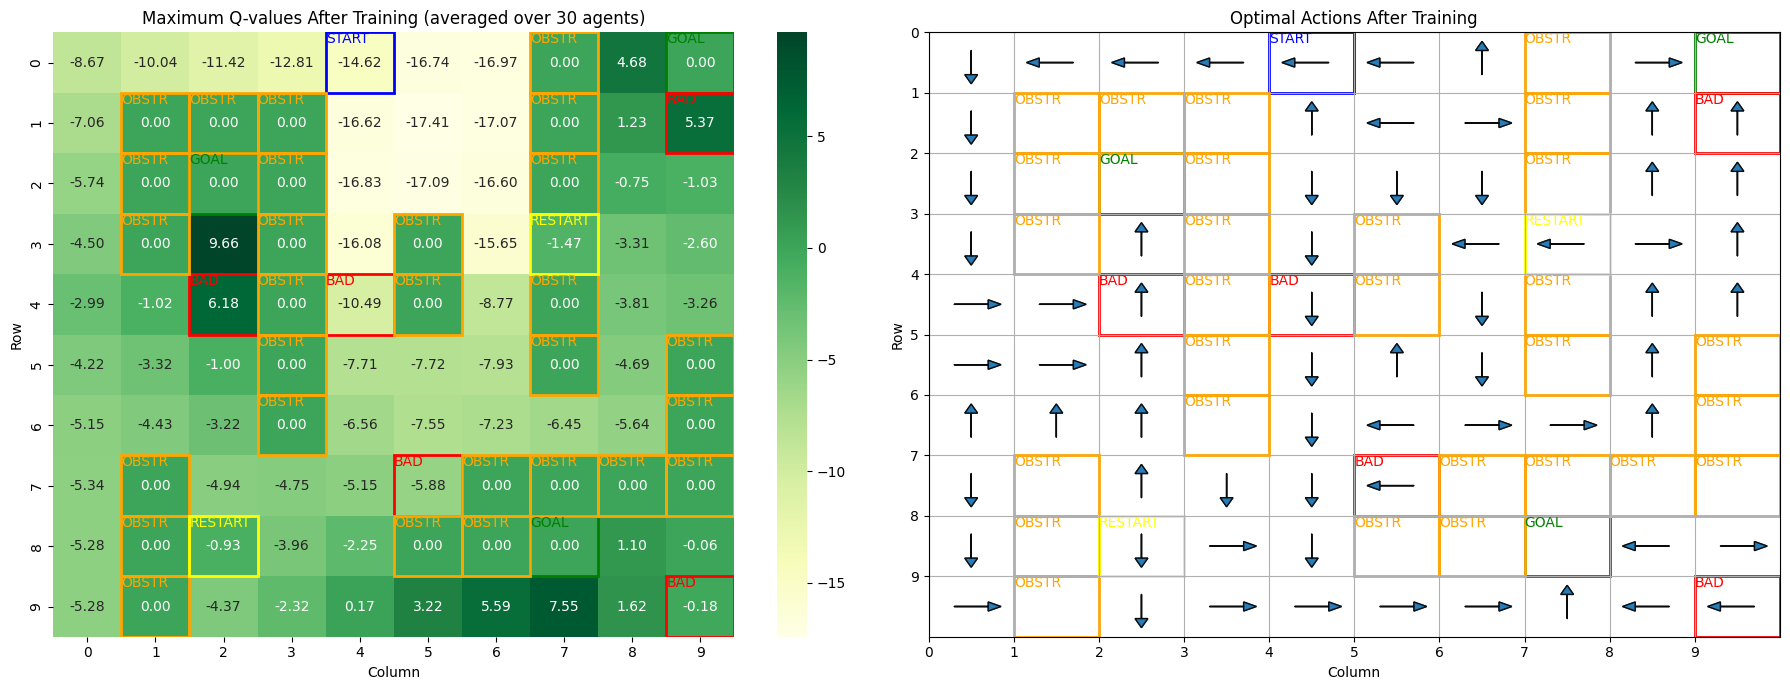

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (4) Configuration id 12

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=False, p=0.7)
results = evaluate_hyperparameters(env, exploration_strategy="epsilon_greedy", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [22:53<00:00, 21.45s/it]  


Best hyperparameters are:
learning_rate: 0.1
discount_factor: 1.0
exploration_parameter: 0.001
Mean reward using best hyperparameters: -35.489266666666666
Standard deviation of reward using best hyperparameters: 29.325689047810773


1. Plot reward curves (during the training phase with the best hyperparameters).

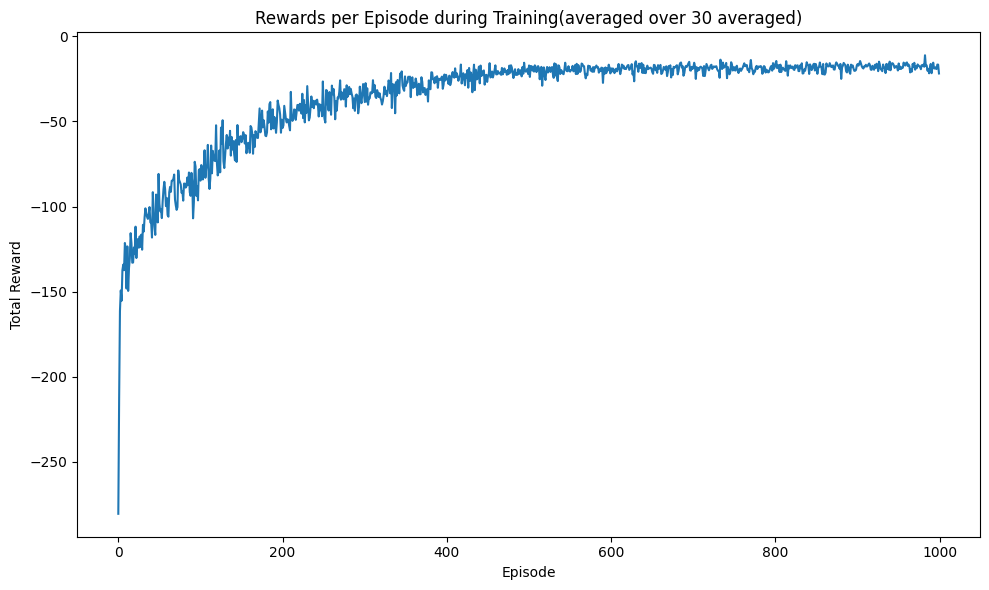

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

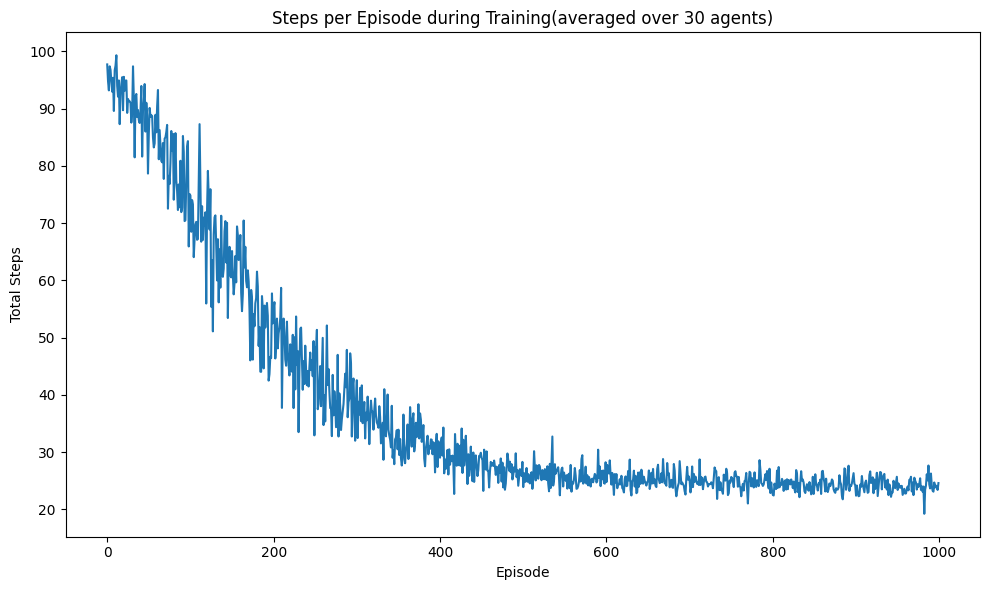

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

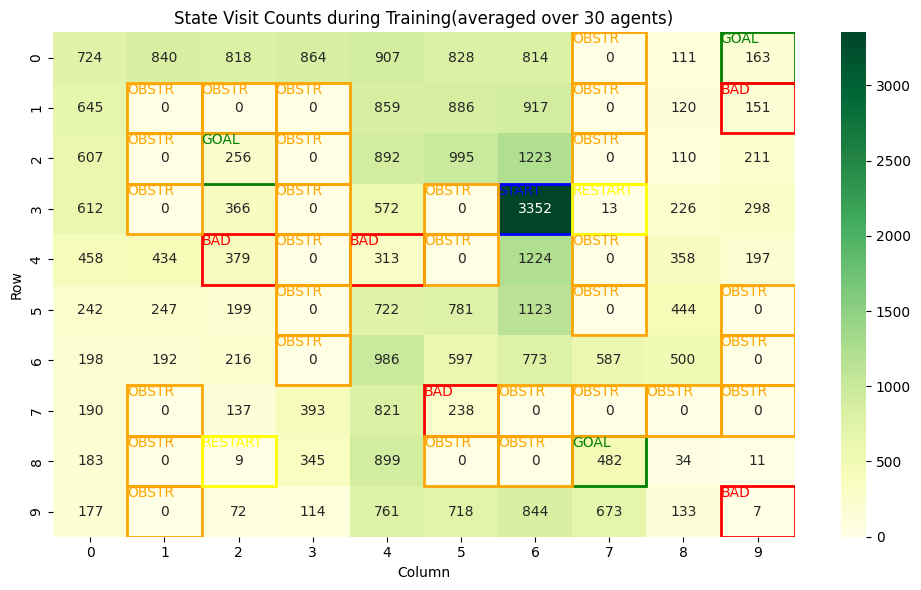

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

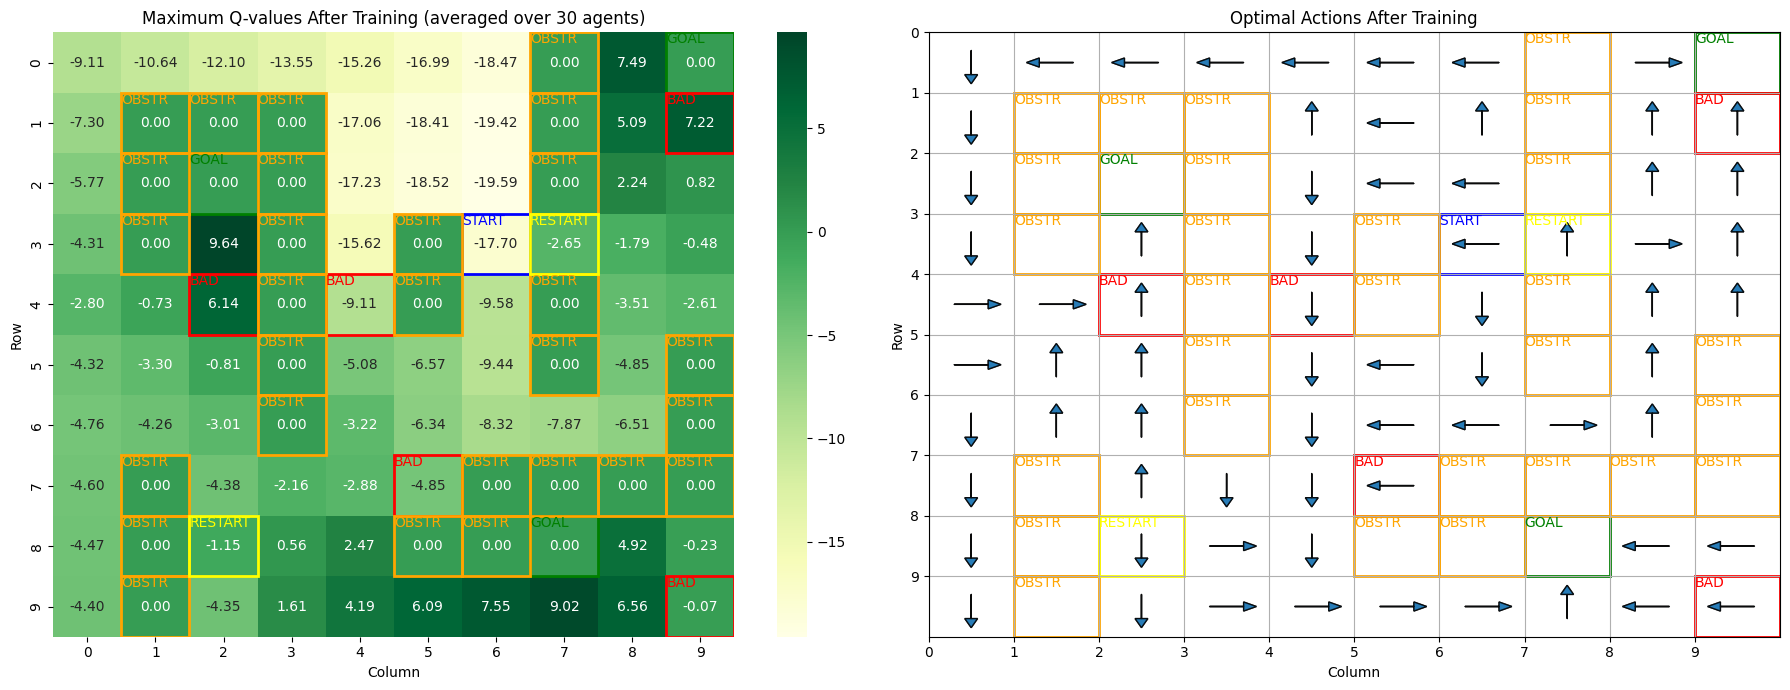

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (5) Configuration id 13

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [48:07<00:00, 45.12s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 1.0
exploration_parameter: 0.1
Mean reward using best hyperparameters: -9.060666666666666
Standard deviation of reward using best hyperparameters: 14.905502324831444


1. Plot reward curves (during the training phase with the best hyperparameters).

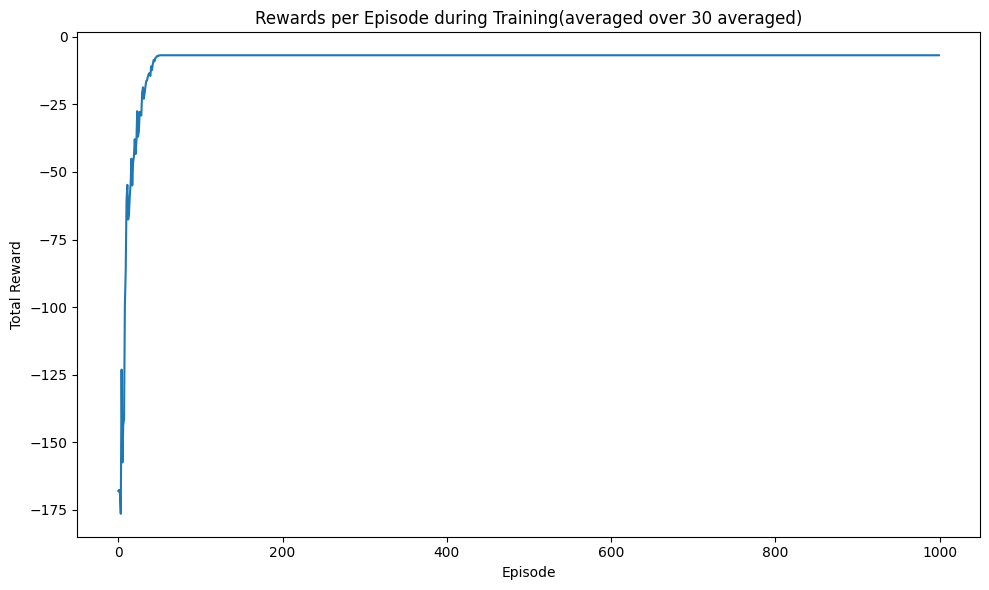

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

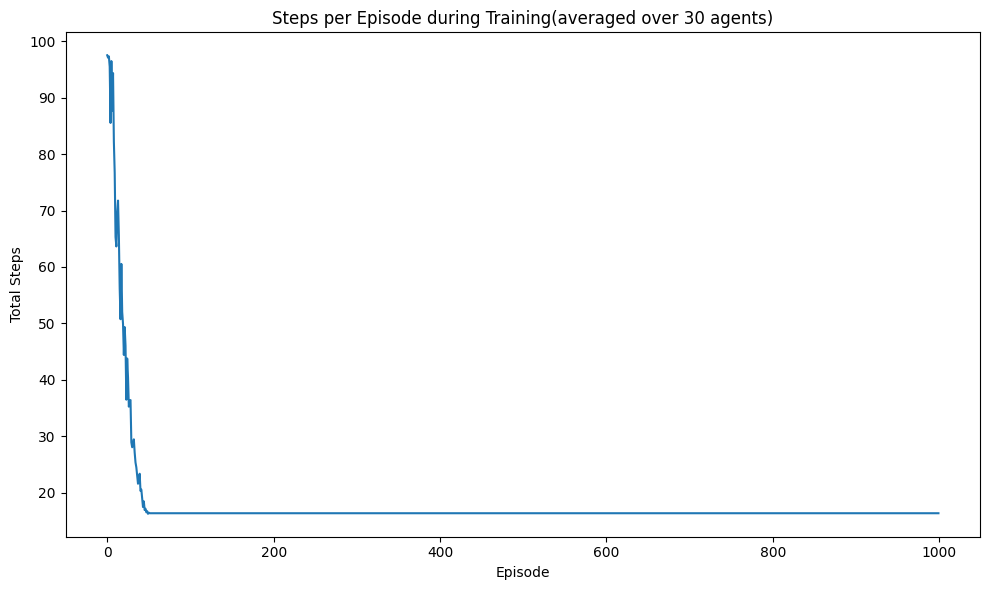

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

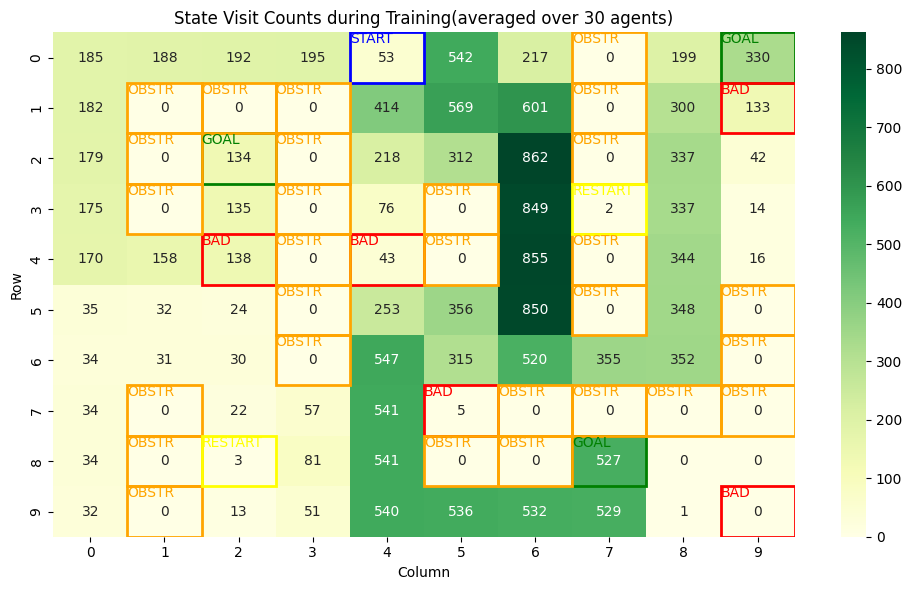

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

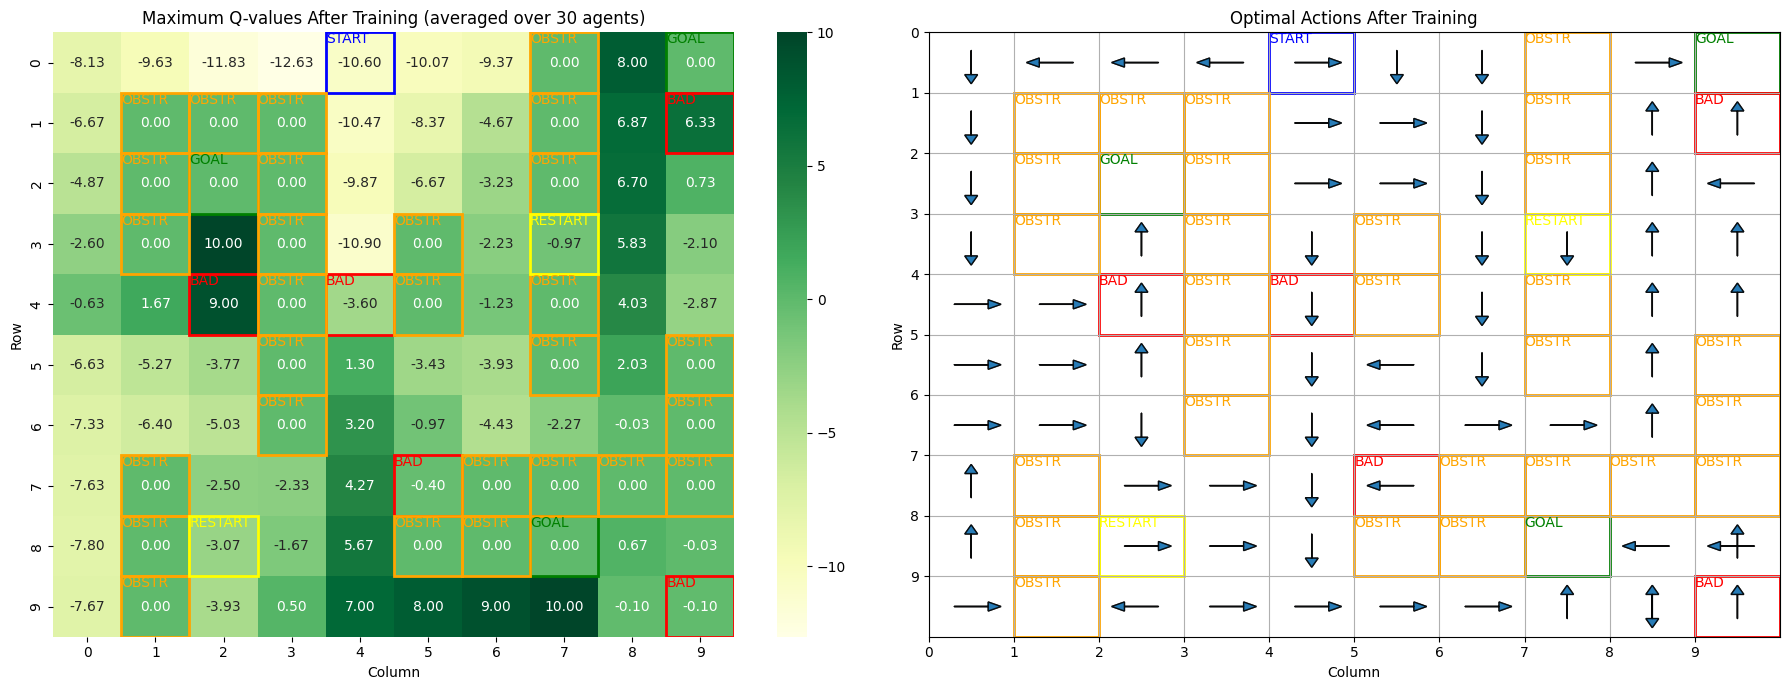

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (6) Configuration id 14

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=False, p=1)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [44:12<00:00, 41.44s/it]  


Best hyperparameters are:
learning_rate: 1.0
discount_factor: 0.8
exploration_parameter: 0.1
Mean reward using best hyperparameters: -3.5255
Standard deviation of reward using best hyperparameters: 15.19125544424233


1. Plot reward curves (during the training phase with the best hyperparameters).

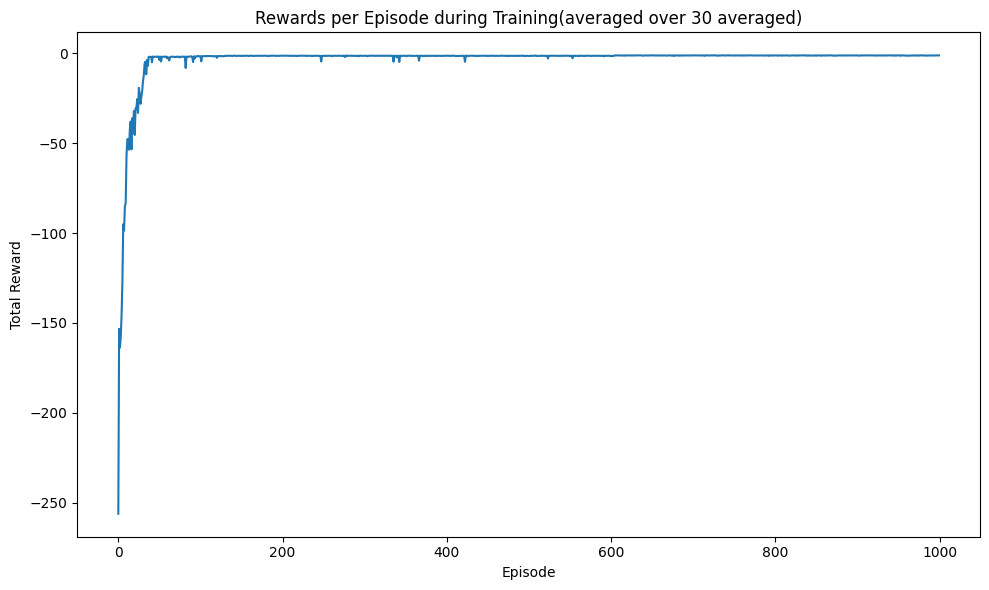

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

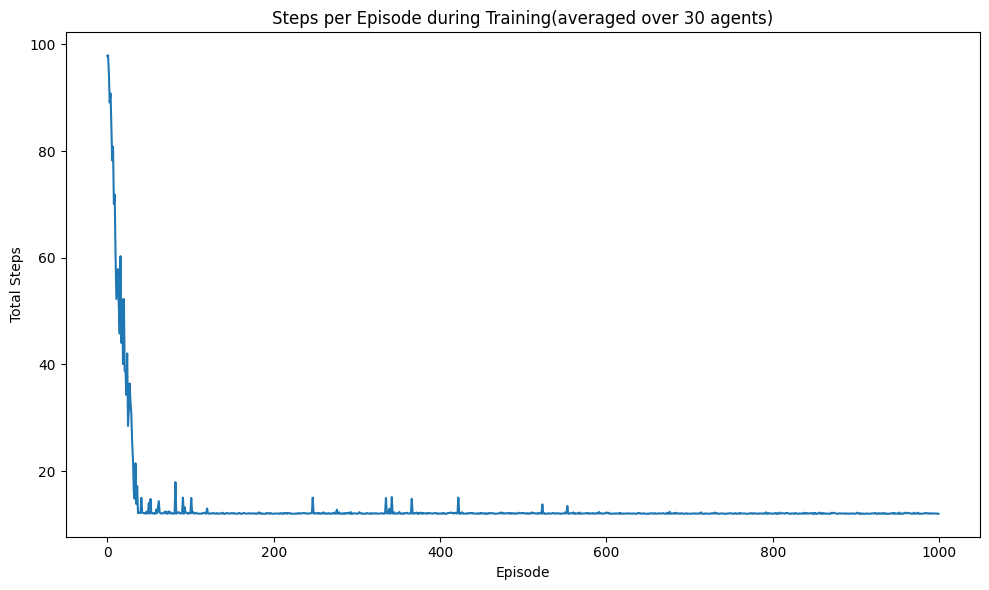

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

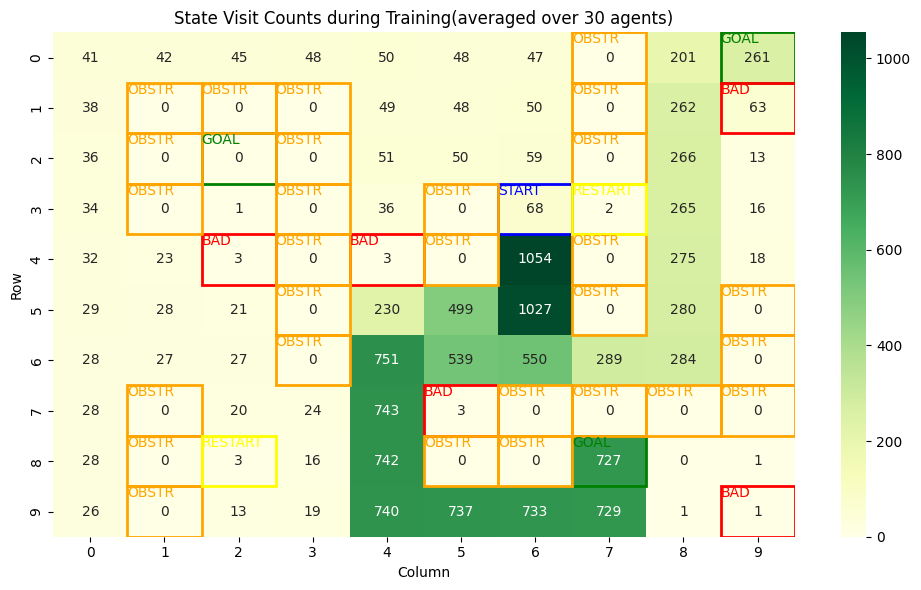

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

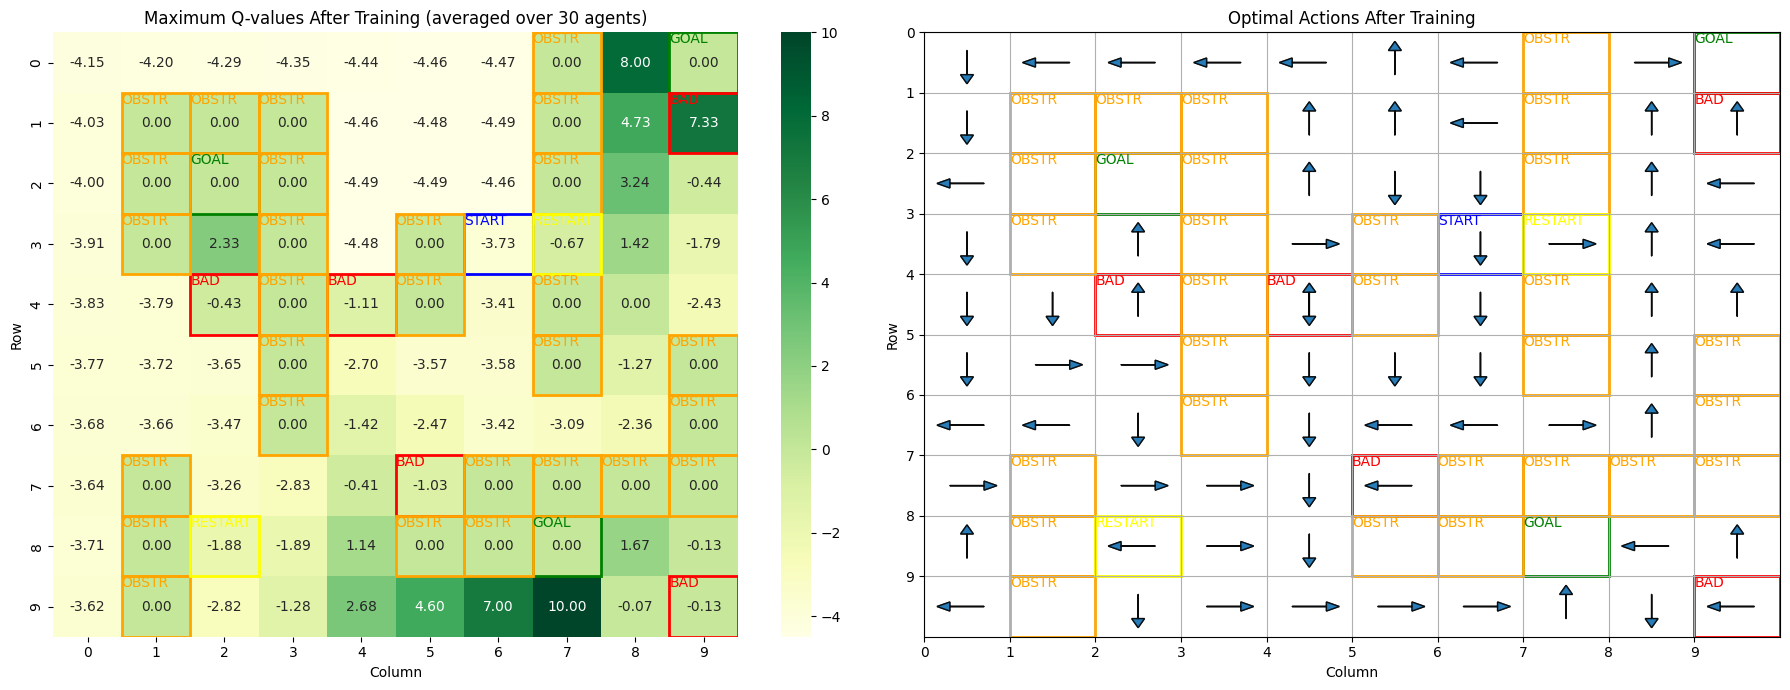

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (7) Configuration id 15

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[0,4]]), wind=False, p=0.7)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [59:02<00:00, 55.36s/it]  


Best hyperparameters are:
learning_rate: 0.1
discount_factor: 1.0
exploration_parameter: 0.01
Mean reward using best hyperparameters: -32.35233333333333
Standard deviation of reward using best hyperparameters: 31.53935106603601


1. Plot reward curves (during the training phase with the best hyperparameters).

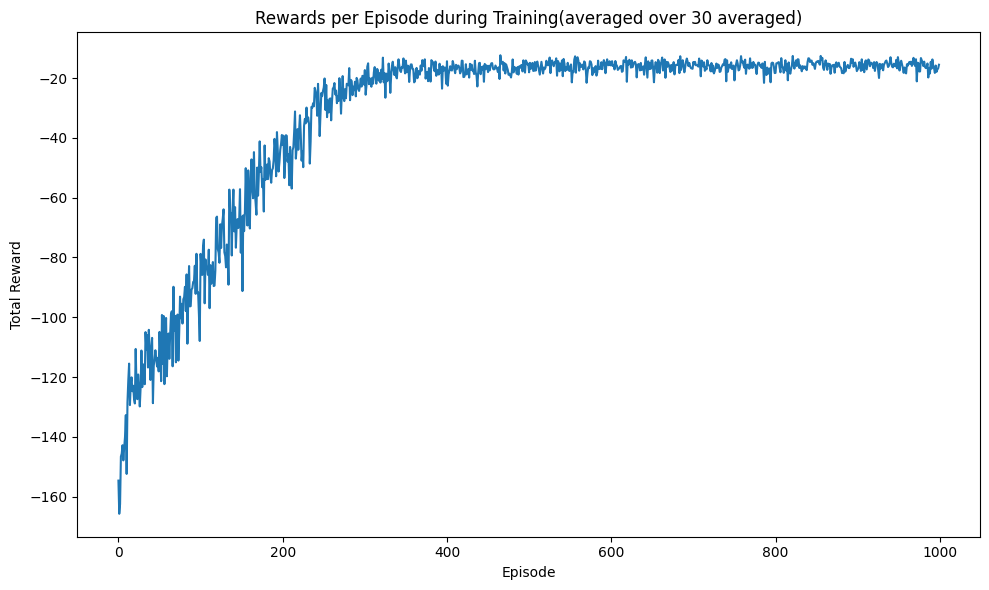

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

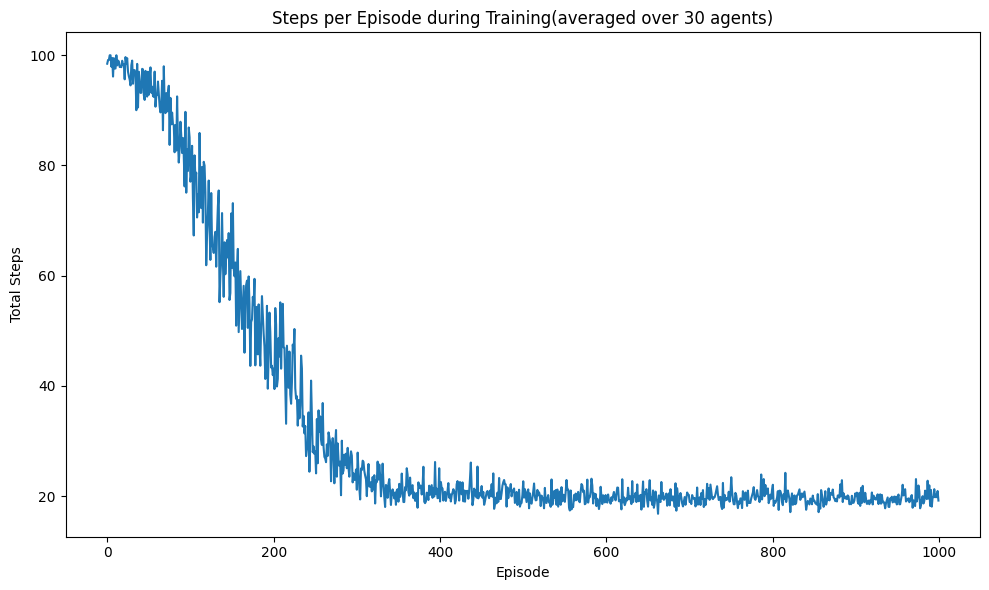

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

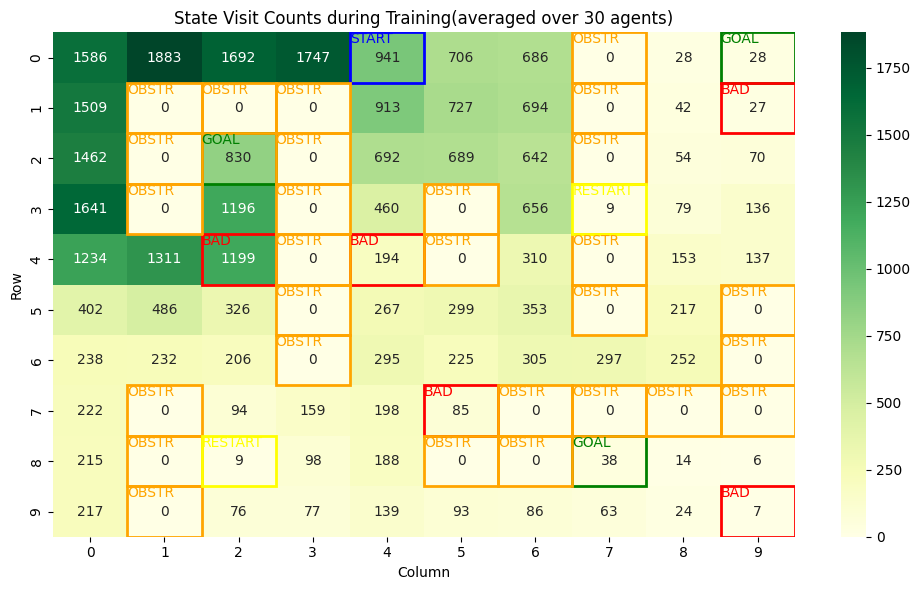

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

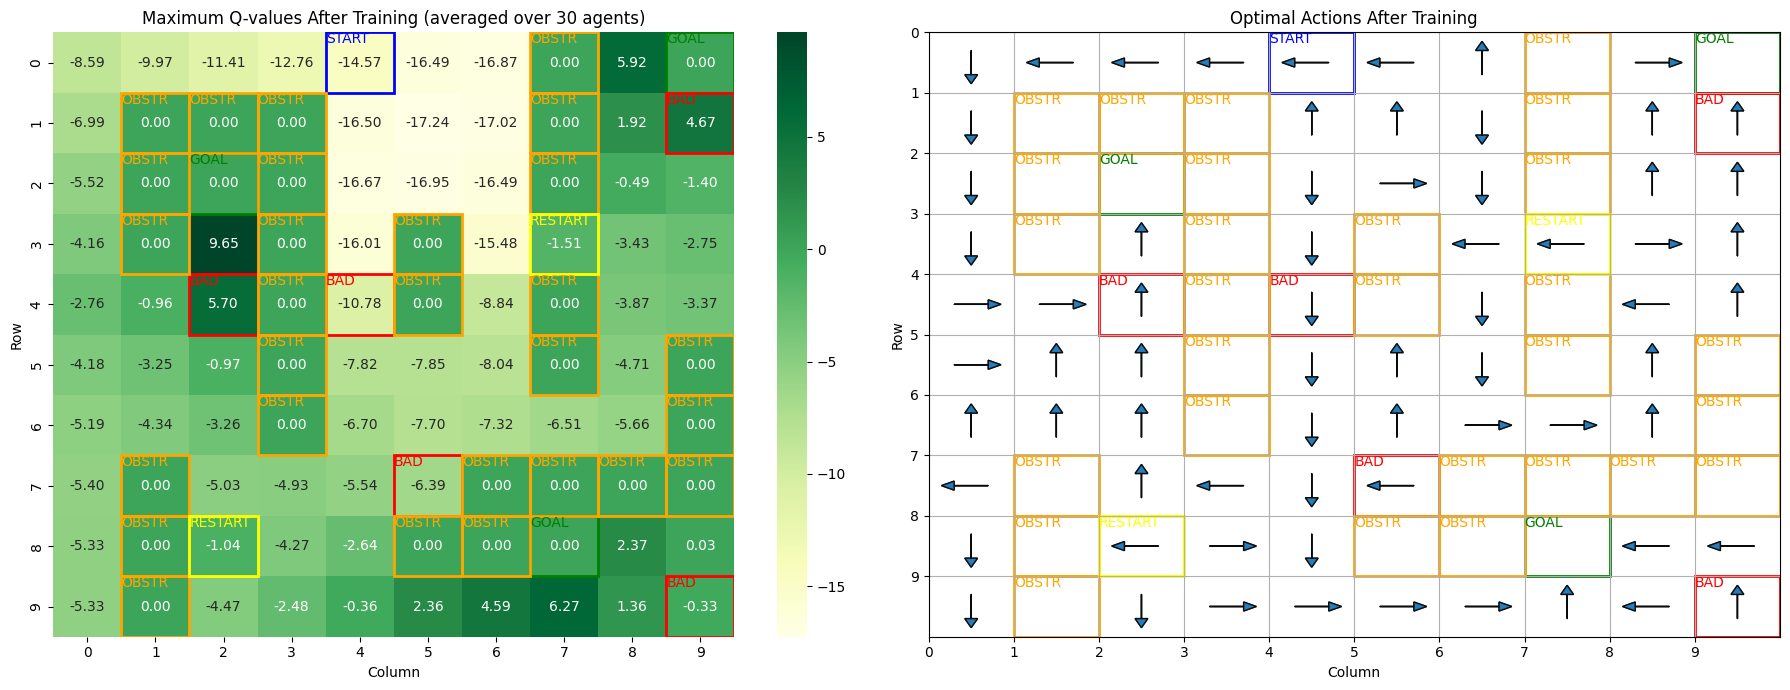

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

### (8) Configuration id 16

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
env = environment_creation(start_state=np.array([[3,6]]), wind=False, p=0.7)
results = evaluate_hyperparameters(env, exploration_strategy="softmax", learning_algorithm=qlearning)
best_result = results[0]
alpha = best_result['learning_rate']
gamma = best_result['discount_factor']
exploration_parameter = best_result['exploration_parameter']

print("\nBest hyperparameters are:")
print('learning_rate:', alpha)
print('discount_factor:', gamma)
print('exploration_parameter:', exploration_parameter)

print('Mean reward using best hyperparameters:', best_result['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', best_result['std_reward'])

Running 64 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 64/64 [58:55<00:00, 55.24s/it]  


Best hyperparameters are:
learning_rate: 0.1
discount_factor: 1.0
exploration_parameter: 0.01
Mean reward using best hyperparameters: -35.62113333333333
Standard deviation of reward using best hyperparameters: 29.60000315397881


1. Plot reward curves (during the training phase with the best hyperparameters).

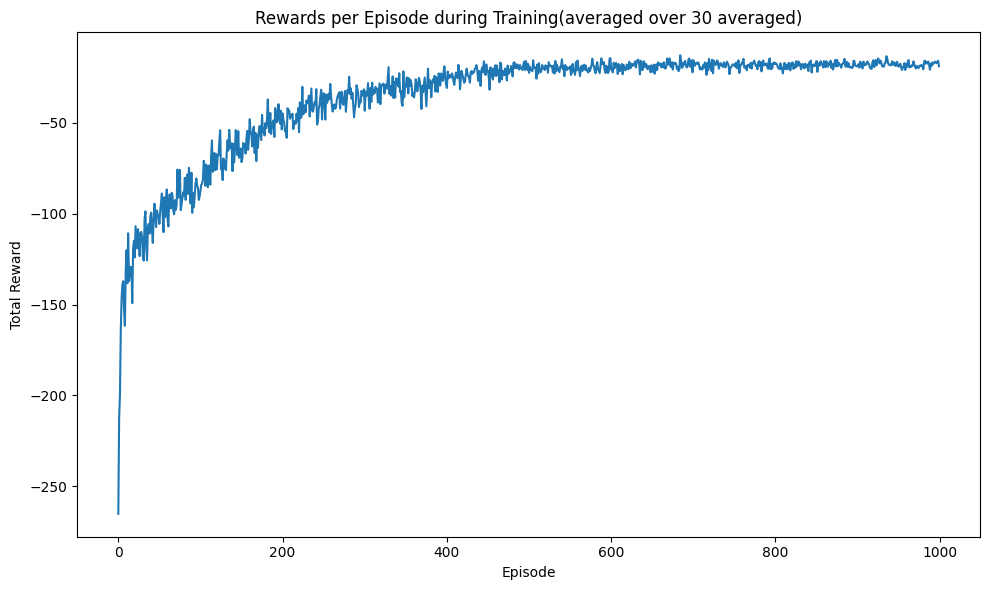

In [ ]:
# write your code here
plot_rewards(best_result['rewards_per_episode'])

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

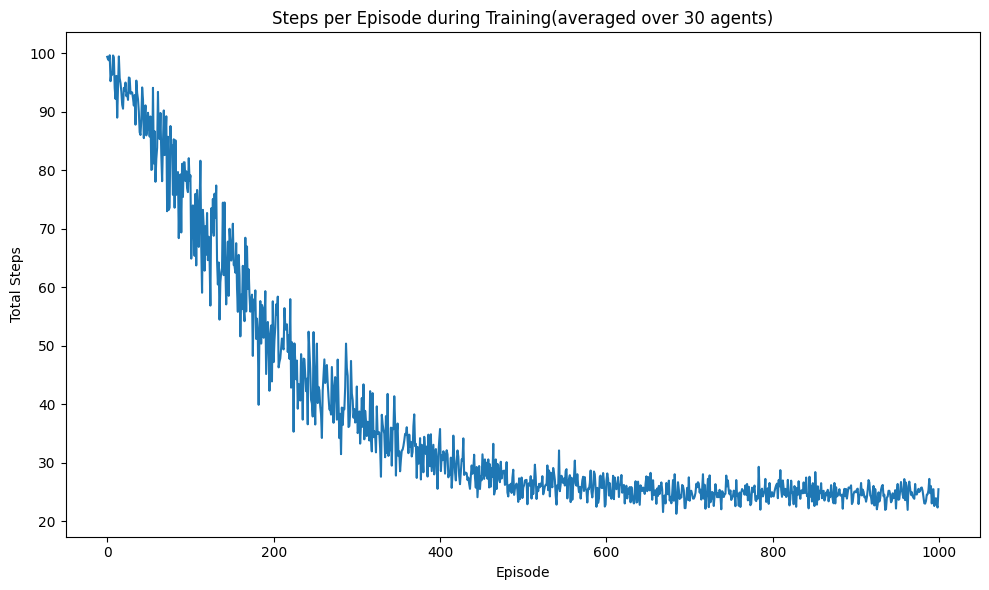

In [ ]:
# write your code here
plot_steps(best_result['steps_per_episode'])

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

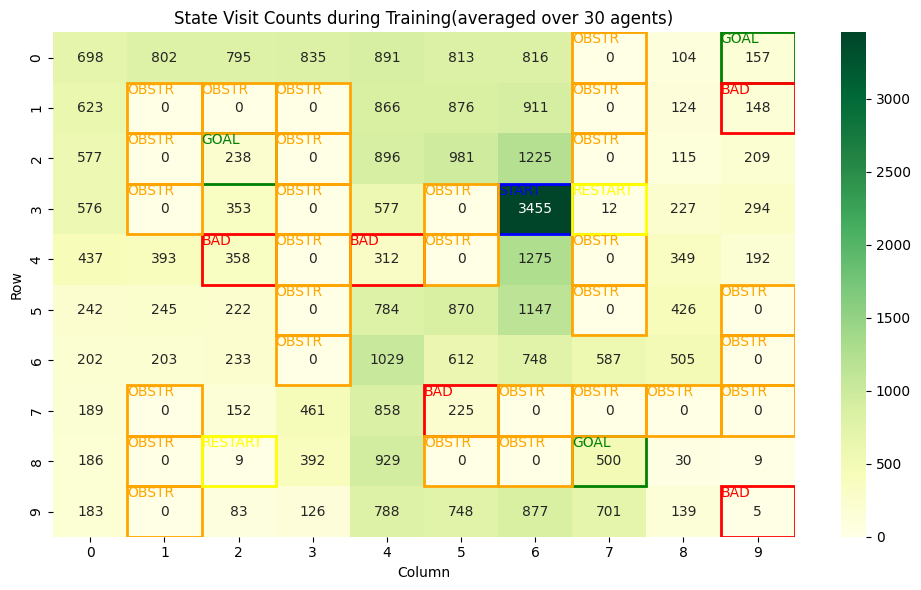

In [ ]:
# write your code here
plot_state_visit_heatmap(best_result['num_visits'], env)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

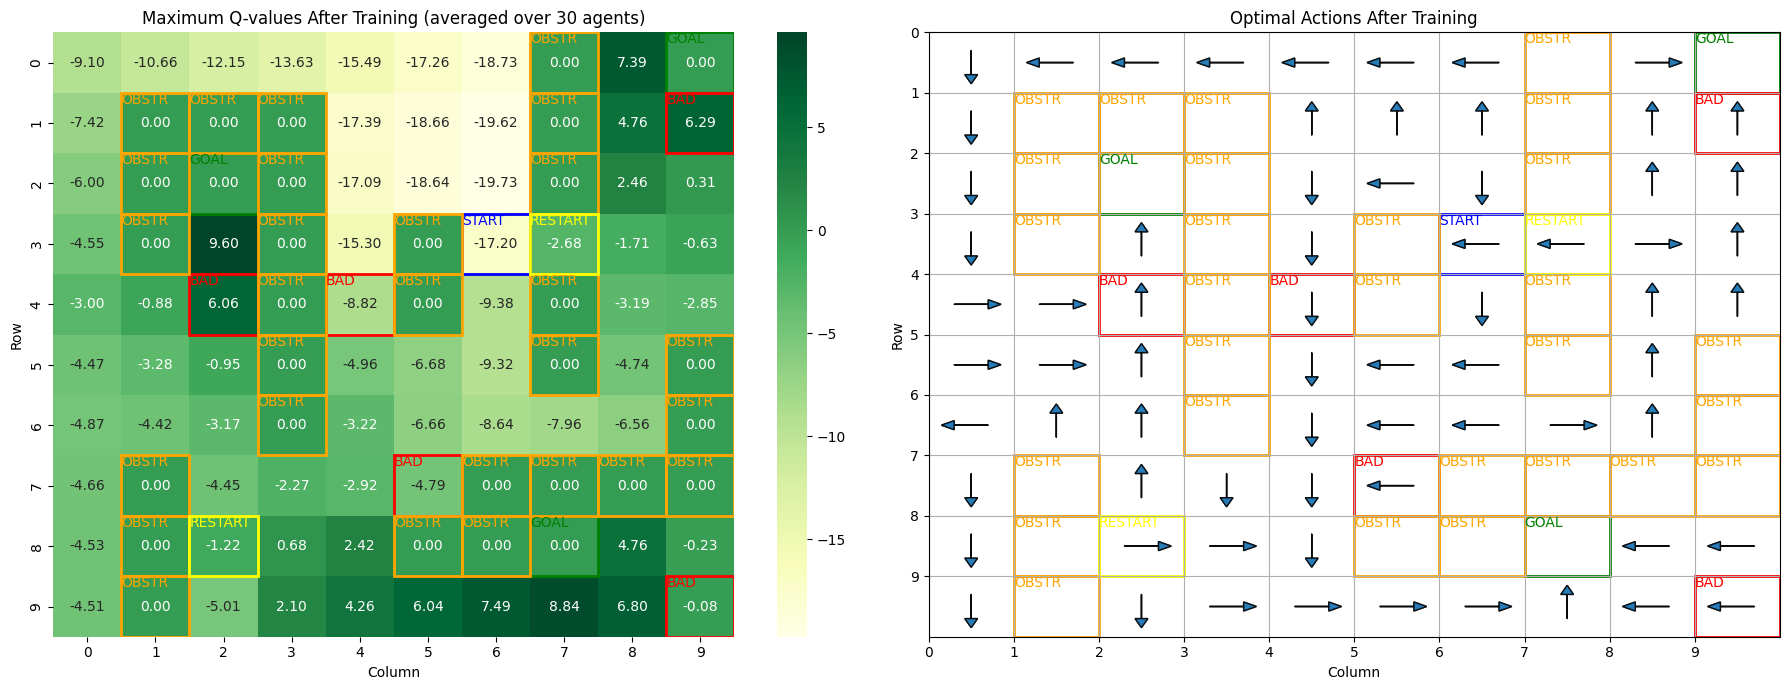

In [ ]:
# write your code here
plot_q_values_and_policy(best_result['Q'], env)

## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

#### **Hyperparameter Selection**  

##### **Exploration Strategy**  
- **Epsilon-Greedy**: ε = 0.001 (consistent across all configurations), representing the **lowest possible exploration rate** among the available options, promoting more exploitation of learned policies.  
- **Softmax Exploration**: Temperature varies between **0.01–0.1**, favoring **lower values** to reduce randomness and encourage more focused exploration based on learned state values.  

##### **Learning Rate (α)**  
- **α = 1.0** (consistent across all configurations), ensuring **fast learning** from temporal-difference (TD) updates.

##### **Discount Factor (γ)**  
- **0.7-0.8** when **wind is off** and starting from **(3,6)**, to emphasize short-term rewards.  
- **0.9-1.0** for all other configurations, prioritizing long-term rewards.  


#### **Policy Behavior Analysis**  

##### **Wind-Off Scenarios**  
- **Softmax Exploration:** The agent tends to navigate toward **goal (8,7)** but also visits **goal (0,9)** with notable frequency.  
- **Epsilon-Greedy:**  The agent prioritizes **goal (0,9)** while still showing significant footfall at **goal (8,7)**.  
- **Common Behavior:**  Across all wind-off scenarios, the agent learns policies that avoid **avoiding bad states** and **restart zones**.  

##### **Wind-On Scenarios**  
- **Starting from (0,4):**  
  - The agent learns to take the **shorter path to goal (2,2)** despite the penalty of passing through a bad state.  
  - This indicates that the agent values **efficiency over safety** when wind is present, as shorter paths offer higher overall returns despite penalties.  

- **Starting from (3,6):**  
  - The agent strongly favors **goal (0,9)** due to its **higher reward efficiency** under windy conditions.  
  - Wind effects likely guide the agent toward the **right side of the grid**:  
    - At the divergence point near **(5,6)**, the wind's influence steers the agent toward **goal (0,9)** rather than **goal (8,7)**, making it the most stable and reward-efficient path.  
  - The agent shows **limited exploration** of paths towards other goals, possibly due to unfavorable wind patterns.

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

#### **Effect of Wind and Start States on Agent Behavior**  

- **Wind-Off Scenarios:**  
   - The agent consistently learns to **avoid penalized states**, optimizing its path to minimize exposure to negative rewards.  
   - Exploration is more **balanced**, leading to distributed visitation patterns across multiple goal states.  
   - **With epsilon-greedy exploration strategy**, **goal (0,9)** becomes the dominant choice, though **goal (8,7)** is also frequently visited.  
   - **With softmax exploration strategy**, **goal (8,7)** becomes the preferred target, with **goal (0,9)** remaining a secondary choice.  

- **Wind-On Scenarios:**  
   - The agent tends to focus on a **single goal**, visiting it most of the time.  
   - Exploration is **restricted** to the upper part of the grid, and **goal (8,7)** is visited less frequently.  
   - **Starting from (0,4):**  
     - The agent favors **goal (2,2)** despite the negative reward state, indicating a preference for **shorter, higher-reward trajectories** over longer, safer routes.  
   - **Starting from (3,6):**  
     - The agent strongly prefers **goal (0,9)** due to its **higher reward efficiency** in windy conditions, as the wind pushes the agent toward the right side of the grid.  
     

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

#### **Hyperparameter Selection**  

- **Stochastic Environments (p = 0.7):**  
   - The **learning rate** is reduced to **0.1** to ensure more stable updates under uncertain conditions.  
   - **Exploration is lower**, with **ε = 0.001** (epsilon-greedy) and **temperature = 0.01** (softmax), minimizing deviations caused by randomness.  
   - The **discount factor remains high (γ = 1)** to reinforce long-term reward maximization.  

- **Deterministic Environments (p = 1):**  
   - The agent learns more aggressively with a **learning rate of 1**.  
   - **Exploration is higher**, with **ε = 0.01** (epsilon-greedy) and **temperature = 0.1** (softmax), encouraging broader state-space coverage.  
   - The **discount factor is lower (γ = 0.7-0.8)** in most of the cases, to prioritize short-term rewards.  

#### **Policy Behavior Analysis**  

##### **Behavior in Deterministic Settings**  
- The agent consistently **avoids negative reward states**, even if it requires taking longer paths.  
- **Starting from (0,4):**  
   - The shortest path leads to **goal (2,2)**, but the agent avoids it due to penalties, preferring **(8,7) or (0,9)** as safer, more reliable alternatives.  
- **Starting from (3,6):**  
   - The agent learns a policy that directs it toward **goal (8,7)**.
   - Exploration is more balanced, with the agent also visits **goal (0,9)** a considerable amount of time.  
   
##### **Behavior in Stochastic Settings**  

- **Starting from (0,4):**  
   - Unlike in deterministic settings, the agent **chooses the shorter path to (2,2)**, even if it involves passing through a bad state. This indicates the agent's preference for **shorter, higher-reward trajectories** over longer, safer routes.  
   - The agent **rarely explores paths to other goals**, staying focused on this more direct route.  

- **Starting from (3,6):**  
   - The agent's movement is more **constrained**, with **footfall concentrated around the top and bottom portions** of the state state.  
   - The path to **goal (0,9)** is **less frequently visited** compared to other goals.

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

#### **Effect of Stochasticity and Start States on Agent Behavior**  

- In **stochastic environments**, the agent takes longer to optimize its policy, as shown by the **rewards vs. episode** and **step count vs. episode** graphs.   

##### **Behavior from Start State (3,6):**

- **Stochastic Transitions (p = 0.7):**  
   - The agent **struggles to leave the start state**, as evidenced by **higher visit counts** in this state compared to the non-stochastic case. This is due to the presence of **obstructions and restart states** on both sides, where attempting to move **up or down** can lead to being pushed into an **obstruction or restart state**, causing the agent to remain in the start state.
   - To avoid the restart state, the agent learns to move toward the **obstruction at (3,5)**—  
     - This strategy increases the likelihood of either staying in the same state or moving vertically without triggering a restart.  
   - Once the agent escapes the starting state, it predominantly heads toward **goal (8,9)**, with **goal (2,2)** becoming the second most visited goal.  

- **Deterministic Transitions (p = 1):**  
   - The agent consistently follows a policy that directs it toward **goal (8,7)**.  
   - It almost entirely **avoids goal (2,2)** due to its penalties.  
   - Exploration is more balanced, with footfall distributed across both **goal (8,7)** and **goal (0,9)**.

##### **Behavior from Start State (0,4):**  
- **Stochastic Transitions (p = 0.7):**  
   - The agent learns to take the **shorter path to goal (2,2)** despite passing through a bad state.  
   - This indicates that the agent values **minimizing steps** over **avoiding penalties** in stochastic settings.  
   - The agent **rarely explores paths to other goals**, focusing on this single goal.

- **Deterministic Transitions (p = 1):**  
   - The agent learns to **avoids goal (2,2)**, prioritizing the safer but **longer paths** to **goal (8,7)** or **goal (0,9)**.  
   - Footfall is more evenly distributed between various goals, indicating balanced exploration and effective pathfinding.  